<br> 
<span style="float: right; color: rgb(128, 128, 128); font-size:150%" >  <strong> Final Project - Milestone 1</span>
<span style="float: left; color: rgb(128, 128, 128); font-size:150%"> <strong>  42186 Model-based machine learning (F20)</span>    
    <br>  
  
    
    
  <span style="float: right; color: rgb(128, 128, 128)" >  <strong> Students:</span>
  <span style="float: left; color: rgb(128, 128, 128)"> <strong>  Professors:</span>
<div> 
      <br>  
<div>
  <span style="float: right" > Guðlaug Erlendsdóttir, s185717</span> 
  <span style="float: left"> Filipe Rodrigues</span>
<div> 
    <br>
  <span style="float: right" > Matthías Karl Karlsson, s182306</span> 
  <span style="float: left"> Francisco Camara Pereira</span>
    <br>
<div style="text-align: right"> Steinn Orri Erlendsson, s153716</div>
    
______________

## Table of Contents

### [1. Description of Project](#one)

* ####  [1.1. Research Question](#ResearchQuestion)

### [2. Data](#two)

* #### [2.1 Data Collection and Preprocessing](#two.one)

### [3.Natural Language Preprocessing](#three)

### [4. Descriptive Stats](#four)

### [5. Linear Regression - For comparison](#reg)

### [6. Generative Story & PGM](#six)

### [7. Inital STAN Model](#eight)

### [ Conclusion](#conclusion)


## The Simpsons - Topic Modeling with Latent Dirichlet Allocation(LDA)


In this notebook, topic modeling through Latent Dirichlet Allocation(LDA) is used in order to try uncover the topics that have come up on episodes of The Simpsons through the years. 

Attributes such as `rating` and `viewers` are extracted from [IMDB](IMDB) for the first 600 episodes of The Simpsons. 
Then, for each of these episodes, the description is scraped from [The Simpsons Fandom](page) page. 
There is a lot of data cleaning to be done, as there are a lot of missing values that resulted from the web scraping due to some inconstistency in the pages' setup. 
Natural Language Processing is deployed in order to represent the textual data better. Each episode's description was put through *TF-IDF analysis* in order to obtain a better representation of their description. 

By using LDA for topic modeling, the episodes can be seen as a mixture of topics, and therefore a relationhip between what is happening in the episode and its rating could potentially be made. Finally, a simple linear regression is used for comparison of the model's performance.

---


# 1. Description of Project<a class="anchor" id="one"></a>

For those that have ever watched the television show *The Simpsons*, it is quite known that the quality of episodes have dwindled over the past years. The show has been running for 30 years and it has long gone past its glory days. But what is the reason behind this decline in quality? In this notebook, the topics of each episode of *The Simpsons* is investigated and through *topic modeling* episodes are clustered together in order to see whether the topics of episodes have anything to do with their respective ratings. 

Ratings for 600 episodes were collected from [IMDB](https://www.imdb.com/) and descriptions for each of those episodes was collected from [The Simpsons Wiki Fanpage](https://simpsons.fandom.com/wiki/List_of_Episodes). This information, along with additional information collected from [Wikipedia](https://www.wikipedia.org) such as viewers per episode and airdate, was used in order to create a data set.

The probabilistic topic model *Latent Dirichlet Allocation* was used in order to extract topic proportions and allocations for each episode. These topics were then investigated in order to see if there is any apparent relationship between the topic of episodes over the years and their declining ratings. 

## 1.1. Research Question<a class="anchor" id="ResearchQuestion"></a>

By using *Topic Modeling* and *Latent Dirichlet Allocation*, we hope to uncover some of the hidden features of the episodes. In general, an episode's rating is related to what is happening in the episode. We want to find if there a relationship between the topic of episodes and their respective ratings, so our research question is;

> How do the topic proportions align with the episodes and can they be used to determine an episode's rating?

If the topic allocations and proportions of an episode can help determine an episode's rating, not only have be created a better linear regression model, but we have proven a hypothesis which does seem logical. 

# 2. Data<a class="anchor" id="two"></a>

In this section, the method of collecting and preprocessing both the *ratings* and *description* for each episode is shown. All of the data is collected through web scraping. The websites that were scraped were [IMDB](https://www.imdb.com), [Wikipedia](https://www.wikipedia.org), and [The Simpsons Fandom Wiki Page](https://simpsons.fandom.com/wiki/List_of_Episodes). 

#### Importing packages

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import urllib.request
import io
import re
import os
import os.path
import nltk, re, pprint
from nltk.tokenize import RegexpTokenizer
import sklearn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import collections
import colorsys
import warnings
warnings.filterwarnings("ignore")
from nltk import sent_tokenize
from nltk.stem import SnowballStemmer 
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import Image
sns.set(style="ticks", color_codes=True)
plt.rcParams['figure.figsize'] = (16, 10)
import pystan
import pystan_utils
#make margins smaller 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

## 2.1 Data Collection and Preprocessing<a class="anchor" id="two.one"></a>

### Episode Information <a class="anchor" id="two.one.one"></a>

Getting all episode names, dates and relevant information is possible by scraping Wikipedia. This will serve as a basis for the episode information which will be used throughout the project. 

In [2]:
episode_1_20_url = 'https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes_(seasons_1%E2%80%9320)#Episodes'
episode_21_31_url = "https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes"

In [3]:
res = requests.get(episode_1_20_url).text
soup = BeautifulSoup(res,'html')
arr = []
next_season = 1
for table in soup.find_all('table', class_='wikiepisodetable'):
    if(table.previous.previous.previous.text != 'The Simpsons Movie'):
        season = table.previous.previous.previous.text.split('(')[1].split(')')[0].split(" ")[1]
        for row in table.find_all('tr')[1::1]:
            data = row.find_all(['th','td'])
            no = data[0].text
            no_in_season = data[1].text
            episode_name = data[2].text[1:len(data[2].text)-1] #Remove the " " 
            airdate = data[5].text
            viewers = data[7].text.split("[")[0]
            arr.append([no,season,no_in_season,episode_name,airdate,viewers])
df_1 = pd.DataFrame(arr)
df_1.columns = ['no_overall','season','no_in_season','episode_name','airdate','viewers (millions)']

Seasons 1 to 20:

In [4]:
df_1.head(3)

no_overall season no_in_season                       episode_name  \
0          1      1            1  Simpsons Roasting on an Open Fire   
1          2      1            2                    Bart the Genius   
2          3      1            3                    Homer's Odyssey   

                          airdate viewers (millions)  
0  December 17, 1989 (1989-12-17)               26.7  
1   January 14, 1990 (1990-01-14)               24.5  
2   January 21, 1990 (1990-01-21)               27.5

In [5]:
df_1.tail(3)

no_overall season no_in_season                     episode_name  \
438        439     20           19      Waverly Hills, 9-0-2-1-D'oh   
439        440     20           20  Four Great Women and a Manicure   
440        441     20           21               Coming to Homerica   

                       airdate viewers (millions)  
438   May 3, 2009 (2009-05-03)               6.75  
439  May 10, 2009 (2009-05-10)               5.16  
440  May 17, 2009 (2009-05-17)               5.86

Now, the rest of the seasons are retrieved:

In [6]:
res = requests.get(episode_21_31_url).text
soup = BeautifulSoup(res,'html')
arr = []
next_season = 1
for table in soup.find_all('table', class_='wikiepisodetable'):
    if(table.previous.previous.previous.text != 'The Longest Daycare' and table.previous.previous.previous.text):
        season = table.previous.previous.previous.text.split('(')[1].split(')')[0].split(" ")[1]
        for row in table.find_all('tr')[1::1]:
            data = row.find_all(['th','td'])
            no = data[0].text
            no_in_season = data[1].text
            episode_name = data[2].text[1:len(data[2].text)-1] #Remove the " " 
            airdate = data[5].text
            viewers = data[7].text.split("[")[0]
            arr.append([no,season,no_in_season,episode_name,airdate,viewers])
        if(season=='30'):
            break
df_2 = pd.DataFrame(arr)
df_2.columns = ['no_overall','season','no_in_season','episode_name','airdate','viewers (millions)']

Seasons 21 to 30:

In [7]:
df_2.head(3)

no_overall season no_in_season         episode_name  \
0        442     21            1    Homer the Whopper   
1        443     21            2      Bart Gets a 'Z'   
2        444     21            3  The Great Wife Hope   

                           airdate viewers (millions)  
0  September 27, 2009 (2009-09-27)               8.31  
1     October 4, 2009 (2009-10-04)               9.32  
2    October 11, 2009 (2009-10-11)                7.5

In [8]:
df_2.tail(3)

no_overall season no_in_season                    episode_name  \
217        660     30           21                     D'oh Canada   
218        661     30           22                 Woo-Hoo Dunnit?   
219        662     30           23  Crystal Blue-Haired Persuasion   

                         airdate viewers (millions)  
217  April 28, 2019 (2019-04-28)               1.93  
218     May 5, 2019 (2019-05-05)               1.79  
219    May 12, 2019 (2019-05-12)               1.50

Concatinating them together will create the final dataframe for the episodes:

In [9]:
df_episodes = pd.concat([df_1,df_2])

In [10]:
df_episodes.reset_index(inplace=True)
df_episodes.drop('index',axis=1,inplace=True)

df_episodes['no_overall'] = df_episodes['no_overall'].apply(lambda x: int(x))
df_episodes['season'] = df_episodes['season'].apply(lambda x: int(x))
df_episodes['no_in_season'] = df_episodes['no_in_season'].apply(lambda x: int(x))

It is necessary to clean **season 28**, here episode **607**, are two seperate episodes.

In [11]:
df_episodes.iloc[607]

no_overall                                   608609
season                                           28
no_in_season                                   1213
episode_name          The Great Phatsby Parts 1 & 2
airdate               January 15, 2017 (2017-01-15)
viewers (millions)                             6.90
Name: 607, dtype: object

Splitting the episode up into episode **608** and **609** will make the data make more sense, as the overall episode count will be linear. 

In [12]:
df_episodes.drop(607,axis=0,inplace=True)

In [13]:
insert_into = pd.DataFrame(data = [{'no_overall':608, 'season':28,'no_in_season': 12, 
                            'episode_name':'The Great Phatsby','airdate': 'January 15, 2017 (2017-01-15)', 
                            'viewers (millions)': 6.90}, {'no_overall':609, 'season':28,'no_in_season': 13, 
                            'episode_name':'The Great Phatsby','airdate': 'January 15, 2017 (2017-01-15)', 
                            'viewers (millions)': 6.90}], index=[607,608])

df_episodes = pd.concat([df_episodes.iloc[:608], insert_into, df_episodes[608:]])

### Episode Ratings <a class="anchor" id="two.one.two"></a>

Getting the ratings for each episode is possible by scraping IMDB. There exist several pages of ratings for the series on IMDB. Going through each one of them will yield every episode's rating:

In [14]:
imdb_ratings_url = 'https://www.imdb.com/list/ls052175596/?st_dt=&mode=simple&page={}&ref_=ttls_vw_smp&sort=release_date,asc'
pages = range(1,8)

In [15]:
ratings = []
for page in range(1,8):
    url = imdb_ratings_url.format(page)
    res = requests.get(url).text
    soup = BeautifulSoup(res,'html')
    container = soup.find('div',class_='lister')
    for item in container.find_all('div', class_='lister-item'):
        as_ = item.find('span',class_='lister-item-header').find_all('a')
        episode_name = as_[1].text
        rating = item.find('div',class_='col-imdb-rating').text.strip()
        ratings.append([episode_name,rating])

df_ratings = pd.DataFrame(ratings)
df_ratings.columns = ['episode_name','IMDB rating']

In [16]:
df_ratings.tail(10)

episode_name IMDB rating
671                         Hail to the Teeth           6
672          The Miseducation of Lisa Simpson         6.6
673                                 Frinkcoin         5.9
674                          Bart the Bad Guy         7.3
675                                Screenless         6.6
676                            Better Off Ned         6.5
677                           Highway to Well           7
678  The Incredible Lightness of Being a Baby         6.4
679                           Warrin' Priests           6
680                    Warrin' Priests Part 2         5.6

For this particular project, only the first 660 episodes will be investigated. This decision was made as the last episodes do not have as much description written about them as they are quite new. 

In [17]:
df_ratings = df_ratings[:661]

In [18]:
df_ratings.tail(2)

episode_name IMDB rating
659                 Woo-Hoo Dunnit?         5.9
660  Crystal Blue-Haired Persuasion         5.8

Concatinating these two DataFrames will yield more informative data. However, a simple merge on the names will not do because the names are not exactly identical on IMDB and Wikipedia. The `NaN` values will be looked at and manually fixed: 

In [19]:
df_episodes_ratings = pd.merge(df_episodes, df_ratings, on='episode_name',how='left')

The following episodes do not get a rating after the join because the naming convention are different between IMDB and Wikipedia.

In [20]:
df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()]

no_overall  season  no_in_season  \
13           14       2             1   
21           22       2             9   
28           29       2            16   
88           89       5             8   
90           91       5            10   
123         124       6            21   
127         128       6            25   
128         129       7             1   
130         131       7             3   
134         135       7             7   
137         138       7            10   
149         150       7            22   
152         153       7            25   
161         162       8             9   
170         171       8            18   
209         210      10             7   
210         211      10             8   
217         218      10            15   
222         223      10            20   
225         226      10            23   
239         240      11            14   
251         252      12             4   
256         257      12             9   
262         263      12            15   
263         264      12            16   
286         287      13            18   
290         291      13            22   
293         294      14             3   
318         319      15             6   
321         322      15             9   
327         328      15            15   
353         354      16            19   
377         378      17            22   
379         380      18             2   
384         385      18             7   
386         387      18             9   
392         393      18            15   
397         398      18            20   
401         402      19             2   
412         413      19            13   
413         414      19            14   
438         439      20            19   
448         449      21             8   
460         461      21            20   
479         480      22            16   
486         487      23             1   
504         505      23            19   
506         507      23            21   
518         519      24            11   
519         520      24            12   
522         523      24            15   
575         576      27             2   
580         581      27             7   
600         601      28             5   
623         624      29             6   
629         630      29            12   

                                          episode_name  \
13                                    Bart Gets an "F"   
21                            Itchy & Scratchy & Marge   
28                              Bart's Dog Gets an "F"   
88                              Boy-Scoutz 'n the Hood   
90   $pringfield (or, How I Learned to Stop Worryin...   
123                                  The PTA Disbands!   
127                     Who Shot Mr. Burns? (Part One)   
128                     Who Shot Mr. Burns? (Part Two)   
130                  Home Sweet Homediddly-Dum-Doodily   
134                                    King-Size Homer   
137             The Simpsons 138th Episode Spectacular   
149  Raging Abe Simpson and His Grumbling Grandson ...   
152                                  Summer of 4 Ft. 2   
161  El Viaje Misterioso de Nuestro Jomer (The Myst...   
170                 Homer vs. the Eighteenth Amendment   
209                                   Lisa Gets an "A"   
210                 Homer Simpson in: "Kidney Trouble"   
217       Marge Simpson in: "Screaming Yellow Honkers"   
222                    The Old Man and the "C" Student   
225                          Thirty Minutes over Tokyo   
239                        Alone Again, Natura-Diddily   
251                               Lisa the Tree Hugger   
256                                               HOMR   
262                               Hungry, Hungry Homer   
263                                     Bye Bye Nerdie   
286                              I Am Furious (Yellow)   
290                      Poppa's Got a Brand New Badge   
293                  Bart vs. Lisa vs. the 

A list of the names of the episodes that are missing their ratings can be created: 

In [21]:
missing = df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()].reset_index()
missing_episodes = missing['index']
for episode in missing_episodes:
    print(df_ratings.iloc[episode]['episode_name'],df_ratings.iloc[episode]['IMDB rating'])

Bart Gets an F 8.2
Itchy and Scratchy and Marge 8.1
Bart's Dog Gets an F 7.5
Boy Scoutz 'n the Hood 8.7
$pringfield (Or, How I Learned to Stop Worrying and Love Legalized Gambling) 8.6
The PTA Disbands 8.1
Who Shot Mr. Burns? Part One 9.2
Who Shot Mr. Burns? Part Two 9
Home Sweet Home-Dum-Diddly Doodily 8.4
King Size Homer 9
The Simpsons 138th Episode Spectacular! 7.5
Raging Abe Simpson and His Grumbling Grandson in 'The Curse of the Flying Hellfish' 8.4
Summer of 4'2" 8.4
El Viaje Misterioso De Nuestro Jomer 8.6
Homer vs. the 18th Amendment 8.9
Lisa Gets an 'A' 8.1
Homer Simpson in: 'Kidney Trouble' 7.3
Marge Simpson in 'Screaming Yellow Honkers' 7.3
The Old Man and the 'C' Student 7.3
Thirty Minutes Over Tokyo 8
Alone Again, Natura-Diddly 7.7
Lisa the Treehugger 7.1
Homr 8.1
Hungry Hungry Homer 7.5
Bye Bye Nerdy 6.6
I Am Furious Yellow 7.7
Papa's Got a Brand New Badge 7.8
Bart vs. Lisa vs. 3rd Grade 7.1
Today, I Am a Clown 6.4
I, (Annoyed Grunt)-Bot 7.2
Co-Dependent's Day 6.7
Thank G

As can be seen by comparing the two lists, these are the episodes that are missing a rating in the final dataframe. Now, an array can be created with the ratings of these episodes, extracted from `df_ratings`. 

In [22]:
missing_ratings = []
for episode in missing_episodes:
    missing_ratings.append([episode,df_episodes.iloc[episode]['episode_name'],df_ratings.iloc[episode]['IMDB rating']])

In [23]:
for episode in missing_ratings: 
    index = episode[0]
    rating = episode[2]
    df_episodes_ratings.at[index, 'IMDB rating'] = rating

In [24]:
df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()]

Empty DataFrame
Columns: [no_overall, season, no_in_season, episode_name, airdate, viewers (millions), IMDB rating]
Index: []

The DataFrame holding each episode's information along with it's rating is now complete, but the airdate column can use a little bit of cleaning:

In [25]:
df_episodes_ratings.head(2)

no_overall  season  no_in_season                       episode_name  \
0           1       1             1  Simpsons Roasting on an Open Fire   
1           2       1             2                    Bart the Genius   

                          airdate viewers (millions) IMDB rating  
0  December 17, 1989 (1989-12-17)               26.7         8.2  
1   January 14, 1990 (1990-01-14)               24.5         7.7

In [26]:
df_episodes_ratings['year'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[0])
df_episodes_ratings['month'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[1].split('-')[0])
df_episodes_ratings['day'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[2].replace(")",""))

In [27]:
df_episodes_ratings.head(2)

no_overall  season  no_in_season                       episode_name  \
0           1       1             1  Simpsons Roasting on an Open Fire   
1           2       1             2                    Bart the Genius   

                          airdate viewers (millions) IMDB rating  year month  \
0  December 17, 1989 (1989-12-17)               26.7         8.2  1989    12   
1   January 14, 1990 (1990-01-14)               24.5         7.7  1990    01   

  day  
0  17  
1  14

The Airdate column can now be dropped:

In [28]:
df_episodes_ratings.drop('airdate',axis=1,inplace=True)

And finally, the IMDB rating column should hold float values:

In [29]:
df_episodes_ratings['IMDB rating'] = df_episodes_ratings['IMDB rating'].apply(lambda x: float(x))

There are still some `NaN` values in the column `viewers (millions)`

In [30]:
df_episodes_ratings[df_episodes_ratings['viewers (millions)'] == 'N/A']

no_overall  season  no_in_season              episode_name  \
159         160       8             7  Lisa's Date with Density   
160         161       8             8           Hurricane Neddy   
172         173       8            20         The Canine Mutiny   

    viewers (millions)  IMDB rating  year month day  
159                N/A          7.8  1996    12  15  
160                N/A          8.8  1996    12  29  
172                N/A          7.6  1997    04  13

These values will be set as the average of the viewers for the season that they belong to.

In [31]:
avg_season_8 = np.average([float(viewer) for viewer in df_episodes_ratings[(df_episodes_ratings['viewers (millions)'] != 'N/A') & (df_episodes_ratings['season'] == 8)]['viewers (millions)']])

The values that need to be filled in are in places 159, 160 and 172:

In [32]:
fill_na_indices = [index for index in df_episodes_ratings[df_episodes_ratings['viewers (millions)'] == 'N/A'].reset_index()['index']]

In [33]:
for index in fill_na_indices:    
    df_episodes_ratings.at[index,'viewers (millions)'] = avg_season_8

This column should also hold float values.

In [34]:
df_episodes_ratings['viewers (millions)'] = df_episodes_ratings['viewers (millions)'].apply(lambda x: float(x))

In [35]:
df_episodes_ratings.isna().sum()

no_overall            0
season                0
no_in_season          0
episode_name          0
viewers (millions)    0
IMDB rating           0
year                  0
month                 0
day                   0
dtype: int64

In [36]:
df_episodes_ratings.to_csv('episode_ratings.csv')

### Simpsons.fandom Pages of Each Episode <a class="anchor" id="two.one.four"></a>

In order to scour through each episode's description, scraping a Wiki fan-page of the series is necessary.

In [37]:
wiki_url = 'https://simpsons.fandom.com/wiki/List_of_Episodes'

In [38]:
links_array = []
res = requests.get(wiki_url).text
soup = BeautifulSoup(res,'html')
no_overall = 1
for table in soup.find_all('table', class_='wikitable')[1:31]: #Skip the overview table and only take the first 30 seasons
    for row in table.find_all('tr'):
            links = row.find_all('a')
            for link in links:
                if(link['href'].split('/wiki/')[1] != 'The_Simpsons_Movie'):
                    links_array.append([no_overall,link['href'].split('/wiki/')[1]])
                    no_overall = no_overall + 1

In [39]:
df_episode_wiki = pd.DataFrame(links_array)
df_episode_wiki.columns = ['no_overall','wiki_link']

In [40]:
df_episode_wiki

no_overall                                 wiki_link
0             1         Simpsons_Roasting_on_an_Open_Fire
1             2                           Bart_the_Genius
2             3                         Homer%27s_Odyssey
3             4           There%27s_No_Disgrace_Like_Home
4             5                          Bart_the_General
..          ...                                       ...
656         657                      Girl%27s_in_the_Band
657         658  I%27m_Just_a_Girl_Who_Can%27t_Say_D%27oh
658         659                             D%27oh_Canada
659         660                         Woo-hoo_Dunnit%3F
660         661            Crystal_Blue-Haired_Persuasion

[661 rows x 2 columns]

Again, the episode 'The Great Phatsby' (episode 608/609), is causing problems. It can be solved as we did before:

In [41]:
phatsby_insert = pd.DataFrame({'no_overall':609, 'wiki_link':'The_Great_Phatsby'},index=[608])
phatsby_insert
df_episode_wiki = pd.concat([df_episode_wiki.iloc[:608], phatsby_insert, df_episode_wiki[608:]])
df_episode_wiki.reset_index(inplace=True, drop=True)
df_episode_wiki_no_correction = df_episode_wiki.iloc[609:]
df_episode_wiki_no_correction['no_overall'] = df_episode_wiki_no_correction['no_overall'].apply(lambda x: x+1)
df_episde_wiki = pd.concat([df_episode_wiki.iloc[:608], df_episode_wiki_no_correction])

In [42]:
df_episodes_ratings = pd.merge(df_episodes_ratings,df_episode_wiki)

In [43]:
df_episodes_ratings.head(5)

no_overall  season  no_in_season                       episode_name  \
0           1       1             1  Simpsons Roasting on an Open Fire   
1           2       1             2                    Bart the Genius   
2           3       1             3                    Homer's Odyssey   
3           4       1             4      There's No Disgrace Like Home   
4           5       1             5                   Bart the General   

   viewers (millions)  IMDB rating  year month day  \
0                26.7          8.2  1989    12  17   
1                24.5          7.7  1990    01  14   
2                27.5          7.4  1990    01  21   
3                20.2          7.7  1990    01  28   
4                27.1          8.0  1990    02  04   

                           wiki_link  
0  Simpsons_Roasting_on_an_Open_Fire  
1                    Bart_the_Genius  
2                  Homer%27s_Odyssey  
3    There%27s_No_Disgrace_Like_Home  
4                   Bart_the_General

### Creating Text Files of Episodes <a class="anchor" id="two.one.five"></a>

Here, each description is fetched and saved as a text file in order to attach them to the data set later. Below, a short description is fetched from another section of each episode's wiki website. The following image explains the process. The upper description of the episode is much shorter and will be scraped separately. The latter is a much longer, thorough description and will be scraped below. 

![scrape](scrape.png)

In [44]:
if not os.path.exists('synopsis'):
        os.mkdir('synopsis')
        
not_full_story = ['Mr._Spritz_Goes_to_Washington', 
                  'Three_Gays_of_the_Condo', 
                  'The_Fat_and_the_Furriest', 
                  'Today,_I_Am_a_Clown', 
                  'Simple_Simpson', 
                  'Fat_Man_and_Little_Boy', 
                  'My_Fare_Lady', 
                  'To_Courier_with_Love', 
                  'Lisa_Gets_the_Blues', 
                  'Girl%27s_in_the_Band',
                  'A_Star_is_Born-Again',
                  'Milhouse_Doesn%27t_Live_Here_Anymore']

for season in df_episodes_ratings['season'].unique():
    if not os.path.exists('synopsis/'+'season'+str(season)):
        os.mkdir('synopsis/'+'season'+str(season))

save_path = os.getcwd()+'/synopsis/'
for episode in df_episodes_ratings['wiki_link']:
    syn = " "
    
    res = requests.get("https://simpsons.fandom.com/wiki/{}".format(episode)).text
    ep_number = df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['no_overall'].values[0]
    season = int(df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['season'].values[0])
    
    soup = BeautifulSoup(res,'html')
    
    # Remove all images
    figs = soup.findAll('figure')
    for fig in figs:
        fig.decompose()
        
    h3s = soup.findAll('h3')
    for h3 in h3s:
        h3.decompose()

    if(episode in not_full_story):
        parent = soup.find('span', {'id':'Synopsis'}).parent
        sibling = parent.next_sibling
        while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name==''):
            if(sibling.name == 'p' or sibling.name=='a'):
                syn += ' ' + str(sibling.text)
                sibling = sibling.next_sibling
            else:
                sibling = sibling.next_sibling

    else:
        
        if(soup.find('span', {'id':'Full_Story'})):
            
            if(episode=='HOM%D0%AF'):
                parent = soup.find('span', {'id':'Full_Story'}).parent
                sibling = parent.next_sibling.next_sibling.next_sibling.next_sibling.next_sibling
                while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name=='i'):

                    if(sibling.name == 'p' or sibling.name=='a' or sibling.name=='i'):
                        syn += ' ' + str(sibling.text)
                        sibling = sibling.next_sibling
                    else:
                        sibling = sibling.next_sibling
            if(episode=='I,_(Annoyed_Grunt)-Bot'):
                parent = soup.find('span', {'id':'Full_Story'}).parent
                sibling = parent.next_sibling.next_sibling.next_sibling.next_sibling
                while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name=='i'):

                    if(sibling.name == 'p' or sibling.name=='a' or sibling.name=='i'):
                        syn += ' ' + str(sibling.text)
                        sibling = sibling.next_sibling
                    else:
                        sibling = sibling.next_sibling
            if(episode=='Simpsons_Christmas_Stories'):
                parent = soup.find('span', {'id':'Full_Story'}).parent
                sibling = parent.next_sibling.next_sibling
                syn += ' ' + str(sibling)
                sibling = sibling.next_sibling.next_sibling.next_sibling
                while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name=='i'):
                    if(sibling.name == 'p' or sibling.name=='a' or sibling.name=='i'):
                        syn += ' ' + str(sibling.text)
                        sibling = sibling.next_sibling
                    else:
                        sibling = sibling.next_sibling
            if(episode=='How_the_Test_Was_Won'):
                parent = soup.find('span', {'id':'Full_Story'}).parent
                sibling = parent.next_sibling.next_sibling.next_sibling
                syn += ' ' + str(sibling)
                sibling = sibling.next_sibling
                while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name=='i'):
                    if(sibling.name == 'p' or sibling.name=='a' or sibling.name=='i'):
                        syn += ' ' + str(sibling.text)
                        sibling = sibling.next_sibling
                    else:
                        sibling = sibling.next_sibling
            else:
                parent = soup.find('span', {'id':'Full_Story'}).parent
                sibling = parent.next_sibling

                while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name=='i'):

                    if(sibling.name == 'p' or sibling.name=='a' or sibling.name=='i'):
                        syn += ' ' + str(sibling.text)
                        sibling = sibling.next_sibling
                    else:
                        sibling = sibling.next_sibling

        elif(soup.find('span', {'id':'The_Story'})):
            
            parent = soup.find('span', {'id':'The_Story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name=='i'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling
                    
        elif(soup.find('span', {'id':'Full_story'})):
            
            parent = soup.find('span', {'id':'Full_story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name=='i'):
                if(sibling.name == 'p' or sibling.name=='a' or sibling.name=='i'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

        elif(soup.find('span', {'id':'Plot'})):
            
            parent = soup.find('span', {'id':'Plot'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name=='a' or sibling.name=='i'):
                if(sibling.name == 'p' or sibling.name=='a' or sibling.name=='i'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling
                    
        elif(soup.find('span', {'id':'Full_Story.C2.A0'})):
            
            parent = soup.find('span', {'id':'Full_Story.C2.A0'}).parent
            sibling = parent.next_sibling

            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name=='i'):
                if(sibling.name == 'p' or sibling.name=='a' or sibling.name=='i'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

                    
    complete_name = os.path.join(os.path.expanduser('~'),save_path+'season'+str(season)+'/',str(ep_number)+'.txt')

    with io.open(complete_name, "w", encoding="utf-8") as f: 
        f.write(str(syn))
        f.close()

It is then necessary to copy episode 608 and create episode 609, as these two episodes are the same episode - often referred to as episode "608609". 

In [45]:
save_path = os.getcwd()+'/synopsis/season28/'
path = save_path+"608.txt"
text = io.open(path,'r',encoding='utf-8').read()
with io.open(save_path+'609.txt', "w", encoding="utf-8") as f: 
    f.write(str(text))
    f.close()

In [46]:
rows = []
for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = desc.lower()
        rows.append([ep,desc])
        f.close()

In [47]:
df_desc = pd.DataFrame(rows, columns = ['no_overall','desc'])

In [48]:
df_desc[df_desc['desc']==' ']

no_overall desc
642         643     
645         646     
659         660

#### Scraping for a small synopsis of each episode

As the descriptions for some episode might be quite long and cumbersome, we decided that obtaining a short *synopsis*, which is also represented on the same wiki website, could potentially be a better textual representation of each episode. We suspect that these textual representations of the epsiodes will differ quite a bit. The following scraping will be carried out in a very similar manner to what has been done above.

In [49]:
if not os.path.exists('short_synopsis'):
        os.mkdir('short_synopsis')

synopsis = []

for season in df_episodes_ratings['season'].unique():
    if not os.path.exists('short_synopsis/'+'season'+str(season)):
        os.mkdir('short_synopsis/'+'season'+str(season))

save_path = os.getcwd()+'/short_synopsis/'
for episode in df_episodes_ratings['wiki_link']:
    res = requests.get("https://simpsons.fandom.com/wiki/{}".format(episode)).text
    ep_number = df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['no_overall'].values[0]
    season = int(df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['season'].values[0])
    soup = BeautifulSoup(res,'html')
    if(episode == 'The_Old_Man_and_the_Key'): # An edge case
        syn=soup.find_all('p')[1].text
    elif(soup.find('span', {'id':'Synopsis'})):
        firstp = soup.find('span', {'id':'Synopsis'}).parent.findNext('p')
        syn = firstp.text
        while(firstp.nextSibling.name=='p'):
            syn = str(syn) + ' ' + firstp.nextSibling.text
            firstp = firstp.nextSibling
    elif(soup.find('span', {'id':'Synopsis.'})):
        syn = soup.find('span', {'id':'Synopsis.'}).parent.findNext('p').text
    elif(soup.find('span', {'id':'Summary'})):
        syn = soup.find('span', {'id':'Summary'}).parent.findNext('p').text
    complete_name = os.path.join(os.path.expanduser('~'),save_path+'season'+str(season)+'/',str(ep_number)+'.txt')
    with io.open(complete_name, "w", encoding="utf-8") as f: 
        f.write(str(syn))
        f.close()

In [50]:
save_path = os.getcwd()+'/short_synopsis/season28/'
path = save_path+"608.txt"
text = io.open(path,'r',encoding='utf-8').read()
with io.open(save_path+'609.txt', "w", encoding="utf-8") as f: 
    f.write(str(text))
    f.close()

In [51]:
rows = []
for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("short_synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = desc.lower()
        rows.append([ep,desc])
        f.close()

In [52]:
df_short_desc = pd.DataFrame(rows, columns = ['no_overall','short_desc'])

In [53]:
df_short_desc.sample(5)

no_overall                                         short_desc
528         529  homer, moe, lenny and carl win the springfield...
42           43  homer makes up for his latest example of fathe...
539         540  comic book guy marries a mangaka (a japanese m...
211         212  when homer rescues mark hamill and mayor quimb...
49           50  when the family causes marge to flip out, she ...

In [54]:
df_short_desc[df_short_desc['short_desc']==' ']

Empty DataFrame
Columns: [no_overall, short_desc]
Index: []

## Characters

In [55]:
char_url = 'https://simpsons.fandom.com/wiki/Portal:All_Simpson_Characters'
res = requests.get(char_url).text
soup = BeautifulSoup(res,'html')
characters = []
for item in soup.find_all('div', class_='wikia-gallery-item'):
    wiki_link_container = item.find('div', class_='lightbox-caption')
    if(wiki_link_container.find('a',href=True)):
        wiki_link = wiki_link_container.find('a',href=True)['href']
        characters.append([item.text,wiki_link.replace('/wiki/','')])

In [56]:
df_char = pd.DataFrame(characters)
df_char.columns = ['name', 'char_wiki_link']

In [57]:
df_char['extra_wiki_link'] = df_char['char_wiki_link'].apply(lambda x: x.split('_')[0])

In [58]:
df_char.drop_duplicates(inplace=True)

One thing that must be noted is that some characters will not be referred to by their first name or even last name. For example, Abraham Simpson II will more often than not be referred to as *Grampa* or *Abe*. The same can be said about Charles Montgomery Burns will most likely be referred to as *Mr. Burns* or *Burns*. 

The character of Robert Terwilliger will most likely be referred to as *Sideshow Bob*. 

In [59]:
df_char.at[5,'name'] = 'Abe'
df_char.at[7,'name'] = 'Mr. Burns'

df_char.at[df_char.index[df_char['name'] == 'Robert Terwilliger'].tolist(), 'name'] = 'Sideshow Bob'

In [60]:
df_char.reset_index(inplace=True, drop=True)

In [61]:
first_names = df_char['name'].apply(lambda x: x.split())

In [62]:
fnames = []
for i,names in enumerate(first_names):
    rid = False
    for name in names:
        if('\'s' in name or 's\'' in name):
            rid = True
            break
        elif('the' in name):
            rid = False
        elif(name[0].islower()):
            if(name != 'bin' and name != 'von'):
                rid = True
                break
        elif(name.isdigit()):
            rid = True
            break
    if(rid):
        fname = ''
        for name in names:
            fname = fname + ' ' + name
        fnames.append(fname[1:])

In [63]:
df_char = df_char[~df_char['name'].isin(fnames)]

In [64]:
df_char['name'] = df_char['name'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
df_char['name'] = df_char['name'].apply(lambda x: re.sub(' +', ' ',x))

In [65]:
df_char['name'] = df_char['name'].apply(lambda x: x.replace("\"",""))

In [66]:
df_char.reset_index(inplace=True, drop=True)

In [67]:
# Characters that are irrelevant

rid_of_chars = [18, 120, 138, 255, 254, 253, 260, 276, 281, 287, 288, 295, 315, 482, 487,
                498, 501, 502, 504, 505, 517, 526, 529, 533, 542,543, 547, 557, 559, 561, 562, 
                599, 600, 601, 602, 603, 605, 606, 610, 611, 612, 613, 614, 615, 616, 617, 618, 
                619, 620, 621, 622, 607, 608, 579, 524, 604, 320, 593]

In [68]:
df_char.drop(rid_of_chars,inplace=True)

In [69]:
df_char.reset_index(inplace=True, drop=True)

In [70]:
df_char['name_split'] = df_char['name'].apply(lambda x: str(x).split(' '))
df_char['num_names'] = df_char['name_split'].apply(lambda x: len(x))

In [71]:
df_char.groupby('num_names').count()

name  char_wiki_link  extra_wiki_link  name_split
num_names                                                   
1            92              92               92          92
2           371             371              371         371
3            94              94               94          94
4             9               9                9           9

In [72]:
irr_names = ['State','Black','Blue-Haired','Lawyer','Cowboy','Man','City','Capital','Database',
            'Boy','Little','Fat','Frog','God','Handsome','Judge','Guy','Book','Old','Man','Number','One',
            'Man','Rich','Veterinarian','Poor','Thief','Relative','Manager','Millionaire','Actor','Old',
            'Lady','New','Stop','Rest','Three','Unnamed','Baby','Blow','Horn','E-mail','Kid','White','Chew',
            'Strangles','Talking','Dog','Taquito','Gay','Colonel','Mathemagician','Fish']

In [73]:
names_to_remove = []
for name_split in df_char['name_split']:
    for name in name_split:
        if(len(name)>2 and '.' not in name and name!='The' and name!='the' and name not in irr_names):
            names_to_remove.append(name)

In [74]:
names_to_remove = list(set(names_to_remove))

###  Scripts for the episodes

# <span style="color: red;">simpson csv file</span> 

In [75]:
df_script = pd.read_csv('the-simpsons-by-the-data-QueryResult.csv', low_memory = False)
df_script_episodes = pd.read_csv('the-simpsons-by-the-data-QueryResult_episodes.csv')
df_script_episodes.columns = ['episode_id','episode_name']

In [76]:
df_script_episodes[df_script_episodes['episode_name'].str[-1] == ']']

episode_id                     episode_name
323         598         Friends and Family"[203]
324         599                   The Town"[205]
325         600  Treehouse of Horror XXVII"[207]

In [77]:
df_script_episodes.at[323,'episode_name'] = 'Friends and Family'
df_script_episodes.at[324,'episode_name'] = 'The Town'
df_script_episodes.at[325,'episode_name'] = 'Treehouse of Horror XXVII'

In [78]:
df_script['episode_id'].nunique() == df_script['episode_id'].nunique()

True

In [79]:
df_episode_attributes = df_episodes_ratings[['episode_name','no_overall','season','no_in_season']]

In [80]:
df_script = pd.merge(df_script,df_script_episodes,on='episode_id',how='left')

In [81]:
df_script.sort_values(['episode_id','number']).head(3)

episode_id  number                                      raw_text  \
148761           1       0  (Street: ext. street - establishing - night)   
148762           1       1                       (Car: int. car - night)   
148763           1       2           Marge Simpson: Ooo, careful, Homer.   

       speaking_line raw_character_text raw_location_text  \
148761         false                NaN            Street   
148762         false                NaN               Car   
148763          true      Marge Simpson               Car   

                spoken_words    normalized_text  \
148761                   NaN                NaN   
148762                   NaN                NaN   
148763  Ooo, careful, Homer.  ooo careful homer   

                             episode_name  
148761  Simpsons Roasting on an Open Fire  
148762  Simpsons Roasting on an Open Fire  
148763  Simpsons Roasting on an Open Fire

In [82]:
df_script = pd.merge(df_script,df_episode_attributes,on='episode_name',how='left')

In [83]:
df_script[df_script['season'].isna()]['episode_name'].unique()

array(['The PTA Disbands', 'Alone Again, Natura-diddily',
       'Bye, Bye, Nerdie', "I'm Spelling As Fast As I Can",
       'A Star Is Born-Again', "Thank God It's Doomsday",
       'Million-Dollar Abie', "Dial 'N' for Nerder",
       'How Munched is That Birdie in the Window?', "Ned 'n Edna's Blend",
       'Love is a Many-Splintered Thing'], dtype=object)

In [84]:
df_episodes_ratings[(df_episodes_ratings['episode_name'].str.contains('Nerder')) | 
                    (df_episodes_ratings['episode_name'].str.contains('Natura-')) |
                    (df_episodes_ratings['episode_name'].str.contains('Disbands')) |
                    (df_episodes_ratings['episode_name'].str.contains('Nerdie')) |
                    (df_episodes_ratings['episode_name'].str.contains('Star Is Born')) |
                    (df_episodes_ratings['episode_name'].str.contains('Dollar Abie')) |
                    (df_episodes_ratings['episode_name'].str.contains('Blend')) |
                    (df_episodes_ratings['episode_name'].str.contains('Splintered')) |
                    (df_episodes_ratings['episode_name'].str.contains('Munched')) |
                    (df_episodes_ratings['episode_name'].str.contains('Doomsday')) |
                    (df_episodes_ratings['episode_name'].str.contains('Spelling'))]                    

no_overall  season  no_in_season  \
123         124       6            21   
239         240      11            14   
263         264      12            16   
302         303      14            12   
303         304      14            13   
353         354      16            19   
371         372      17            16   
413         414      19            14   
470         471      22             7   
506         507      23            21   
519         520      24            12   

                                  episode_name  viewers (millions)  \
123                          The PTA Disbands!               11.80   
239                Alone Again, Natura-Diddily               10.80   
263                             Bye Bye Nerdie               16.10   
302              I'm Spelling as Fast as I Can               22.10   
303                       A Star Is Born Again               14.40   
353                   Thank God, It's Doomsday               10.05   
371                        Million Dollar Abie                7.83   
413                        Dial "N" for Nerder                7.30   
470  How Munched Is That Birdie in the Window?                9.38   
506                Ned 'n' Edna's Blend Agenda                4.07   
519            Love Is a Many-Splintered Thing                4.19   

     IMDB rating  year month day                                    wiki_link  
123          8.1  1995    04  16                             The_PTA_Disbands  
239          7.7  2000    02  13                  Alone_Again,_Natura-Diddily  
263          6.6  2001    03  11                               Bye_Bye_Nerdie  
302          7.2  2003    02  16              I%27m_Spelling_as_Fast_as_I_Can  
303          6.9  2003    03  02                         A_Star_is_Born-Again  
353          7.2  2005    05  08                    Thank_God_It%27s_Doomsday  
371          6.3  2006    04  02                          Million-Dollar_Abie  
413          7.3  2008    03  09                      Dial_%22N%22_for_Nerder  
470          6.2  2010    11  28  How_Munched_is_That_Birdie_in_the_Window%3F  
506          6.5  2012    05  13                      Ned_%27N_Edna%27s_Blend  
519          6.1  2013    02  10              Love_is_a_Many-Splintered_Thing

In [85]:
correct_names = [name for name in df_episodes_ratings[(df_episodes_ratings['episode_name'].str.contains('Nerder')) | 
                    (df_episodes_ratings['episode_name'].str.contains('Natura-')) |
                    (df_episodes_ratings['episode_name'].str.contains('Nerdie')) |
                    (df_episodes_ratings['episode_name'].str.contains('Disbands')) |
                    (df_episodes_ratings['episode_name'].str.contains('Star Is Born')) |
                    (df_episodes_ratings['episode_name'].str.contains('Dollar Abie')) |
                    (df_episodes_ratings['episode_name'].str.contains('Blend')) |
                    (df_episodes_ratings['episode_name'].str.contains('Splintered')) |
                    (df_episodes_ratings['episode_name'].str.contains('Munched')) |
                    (df_episodes_ratings['episode_name'].str.contains('Doomsday')) |
                    (df_episodes_ratings['episode_name'].str.contains('Spelling'))]['episode_name']]

In [86]:
correct_names

['The PTA Disbands!',
 'Alone Again, Natura-Diddily',
 'Bye Bye Nerdie',
 "I'm Spelling as Fast as I Can",
 'A Star Is Born Again',
 "Thank God, It's Doomsday",
 'Million Dollar Abie',
 'Dial "N" for Nerder',
 'How Munched Is That Birdie in the Window?',
 "Ned 'n' Edna's Blend Agenda",
 'Love Is a Many-Splintered Thing']

In [87]:
incorrect_names = [name for name in df_script[df_script['season'].isna()]['episode_name'].unique()]

In [88]:
incorrect_names

['The PTA Disbands',
 'Alone Again, Natura-diddily',
 'Bye, Bye, Nerdie',
 "I'm Spelling As Fast As I Can",
 'A Star Is Born-Again',
 "Thank God It's Doomsday",
 'Million-Dollar Abie',
 "Dial 'N' for Nerder",
 'How Munched is That Birdie in the Window?',
 "Ned 'n Edna's Blend",
 'Love is a Many-Splintered Thing']

In [89]:
df_incorrect_names = df_script_episodes[df_script_episodes['episode_name'].isin(incorrect_names)].sort_values('episode_id')
df_incorrect_names_indices = [index for index in df_incorrect_names.reset_index()['index']]

In [90]:
for i,name in enumerate(correct_names):
    df_script_episodes.at[df_incorrect_names_indices[i], 'episode_name'] = correct_names[i]

In [91]:
df_script.drop(['season','no_overall','no_in_season','episode_name'],axis=1,inplace=True)
df_script = pd.merge(df_script,df_script_episodes,on='episode_id',how='left')
df_script = pd.merge(df_script,df_episode_attributes,on='episode_name',how='left')

In [92]:
df_script[df_script['season'].isnull()].groupby('episode_name').count()

Empty DataFrame
Columns: [episode_id, number, raw_text, speaking_line, raw_character_text, raw_location_text, spoken_words, normalized_text, no_overall, season, no_in_season]
Index: []

In [93]:
df_script.sort_values(by=['episode_id','number']).to_csv('scripts.csv')

In [94]:
df_scripts = pd.read_csv('scripts.csv').drop('Unnamed: 0',axis=1)

In [95]:
df_scripts[~df_scripts['normalized_text'].isna()].reset_index(drop=True).normalized_text[0]

'ooo careful homer'

In [96]:
episode_scripts = {}
for i in range(1,569):
    episode_scripts[i] = ''

In [97]:
for i,row in df_scripts[~df_scripts['normalized_text'].isna()].reset_index(drop=True).iterrows():
    episode_scripts[row.no_overall] = episode_scripts[row.no_overall] + ' ' + row.normalized_text

In [98]:
df_episode_scripts = pd.DataFrame.from_dict(episode_scripts, orient='index',columns=['script']).reset_index()
df_episode_scripts.columns = ['no_overall', 'script']

In [99]:
df_episode_scripts[df_episode_scripts['script'].isna()]

Empty DataFrame
Columns: [no_overall, script]
Index: []

## 3. Natural Language Processing<a class="anchor" id="three"></a>

In order to represent the text data better, some useful natural language processing methods will be deployed. 

First, all *stopwords*, along with the words "*episode*" and "*begins*" will be removed from the descriptions as they do not pertain any information about the episode itself, and appear quite often. 

Then, the description is split into *tokens* (words) and lastly we use stemming. For this particular objective, the Snowball (Porter2) stemmer will be used, as it is widely regarded as an improvement of the gentle Porter stemmer and is computationally faster [[REF]](https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg) Then the words can then be analyzed and very infrequent words will be removed, as will very frequent words. 

Character names will also appear quite often in the description of each epsiode. Here, we have chosen to remove them from the description. 

Stop wards will need to be created and appended with some special words that appear more often than they should, e.g. *episode* and *begins*, as this is a description of an episode on a Wiki page. Also, some character names will be added to the stopwords in order to remove them from the description later on. 

In [100]:
stop_words = ['episode','begins']
STOP_WORDS_EN = stopwords.words('english')
for word in STOP_WORDS_EN:
    stop_words.append(re.sub(r'[^\w]', ' ', word).replace(' ',''))

for word in ['episode','begins','homer','marge','bart','maggie','lisa','simpson','simpsons','burns',
             'milhouse','krusty','moe','skinner','wiggum','ned','flanders','simon','smithers','yeah','yes','no','okay','hehe','heh']:
    stop_words.append(word.lower())
for name in names_to_remove:
    stop_words.append(name.lower())

In [101]:
rows = []
stemmer = SnowballStemmer("english") 

for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = re.sub(r'[^\w]', ' ', desc)
        desc = re.sub(" \d+", " ", desc) #removing numbers
        desc = desc.replace(r' +',' ').replace('\n','')
        desc = desc.split(' ')
        desc = [word.lower() for word in desc if word.lower() not in stop_words]
        desc = [stemmer.stem(word.lower()) for word in desc if len(word)>2]
        rows.append([ep, desc])
        f.close()

In [102]:
df_desc = pd.DataFrame(rows, columns = ['no_overall','desc'])
df_desc = df_desc[:600]

Next, a column is created in order to display the length of each description for further analysis and processing of data.

In [103]:
df_desc['desc_len'] = df_desc['desc'].apply(lambda x: len(x))

In [104]:
df_desc[df_desc['desc_len']==0]

Empty DataFrame
Columns: [no_overall, desc, desc_len]
Index: []

In [105]:
df = df_episodes_ratings.merge(df_desc, on='no_overall')

In [106]:
df[df['desc_len']==0]

Empty DataFrame
Columns: [no_overall, season, no_in_season, episode_name, viewers (millions), IMDB rating, year, month, day, wiki_link, desc, desc_len]
Index: []

In [107]:
rows = []
stemmer = SnowballStemmer("english") 

for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("short_synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = re.sub(r'[^\w]', ' ', desc)
        desc = re.sub(" \d+", " ", desc) #removing numbers
        desc = desc.replace(r' +',' ').replace('\n','')
        desc = desc.split(' ')
        trun_desc = desc
        desc = [word.lower() for word in desc if word.lower() not in stop_words]
        desc = [stemmer.stem(word.lower()) for word in desc if len(word)>2]

        rows.append([ep, desc])
        f.close()

In [108]:
df_short_desc = pd.DataFrame(rows, columns = ['no_overall','short_desc'])
df_short_desc = df_short_desc[:600]

In [109]:
df_short_desc['short_desc_len'] = df_short_desc['short_desc'].apply(lambda x: len(x))

In [110]:
df = df.merge(df_short_desc, on='no_overall')

In [111]:
df.columns

Index(['no_overall', 'season', 'no_in_season', 'episode_name',
       'viewers (millions)', 'IMDB rating', 'year', 'month', 'day',
       'wiki_link', 'desc', 'desc_len', 'short_desc', 'short_desc_len'],
      dtype='object')

In [112]:
df.columns = ['no_overall', 'season', 'no_in_season', 'episode_name',
       'mil_viewers', 'rating', 'year', 'month', 'day',
       'wiki_link', 'desc', 'desc_len','short_desc','short_desc_len']

In [113]:
df.drop('wiki_link',axis=1,inplace=True)

In [114]:
df['mil_viewers'] = df['mil_viewers'].apply(lambda x: float(x))

In [115]:
df['day'] = df['day'].replace('22[a]','22')

In [116]:
df['no_overall'] = df['no_overall'].apply(lambda x: int(x))
df['no_in_season'] = df['no_in_season'].apply(lambda x: int(x))
df['season'] = df['season'].apply(lambda x: int(x))
df['year'] = df['year'].apply(lambda x: int(x))
df['month'] = df['month'].apply(lambda x: int(x))
df['day'] = df['day'].apply(lambda x: int(x))
df['rating'] = df['rating'].apply(lambda x: float(x))

The data set now looks like this, where the column *desc* is essentially a bag of words for each episode. 

In [117]:
df.sample(10)

no_overall  season  no_in_season  \
123         124       6            21   
58           59       3            24   
474         475      22            11   
327         328      15            15   
23           24       2            11   
367         368      17            12   
323         324      15            11   
576         577      27             3   
40           41       3             6   
131         132       7             4   

                                episode_name  mil_viewers  rating  year  \
123                        The PTA Disbands!        11.80     8.1  1995   
58         Brother, Can You Spare Two Dimes?        17.20     8.3  1992   
474                              Flaming Moe         6.47     6.6  2011   
327                       Co-Dependents' Day        11.20     6.7  2004   
23   One Fish, Two Fish, Blowfish, Blue Fish        24.20     8.8  1991   
367                            My Fair Laddy         9.51     6.3  2006   
323                    Margical History Tour         8.90     7.1  2004   
576                                 Puffless         3.31     7.0  2015   
40                   Like Father, Like Clown        20.20     7.7  1991   
131                      Bart Sells His Soul        14.80     8.8  1995   

     month  day                                               desc  desc_len  \
123      4   16  [fail, attempt, school, field, trip, appear, c...       235   
58       8   27  [rest, nuclear, power, plant, employe, summon,...        54   
474      1   16  [feel, find, put, tri, cheer, go, gay, nightcl...       127   
327      3   21  [see, newest, cosmic, war, film, gather, shado...       205   
23       1   24  [talk, food, choic, predict, take, famili, new...       173   
367      2   26  [gym, teacher, announc, gone, fall, due, sex, ...       209   
323      2    8  [take, librari, studi, librarian, tell, book, ...       441   
576     10   11  [grampa, watch, televis, turn, tell, mother, f...        99   
40      10   24  [finish, show, decid, free, night, cancel, pla...       152   
131     10    8  [sunday, morn, famili, serv, church, usher, us...       356   

                                            short_desc  short_desc_len  
123  [push, teacher, strike, local, springfieldian,...              14  
58   [half, brother, herb, live, bum, sinc, lose, c...              28  
474  [help, turn, tavern, popular, gay, bar, later,...              24  
327  [trip, vineyard, plan, drink, bing, togeth, cr...              26  
23   [convinc, famili, tri, new, sushi, restaur, su...              23  
367  [elementari, school, new, gym, teacher, play, ...              34  
323  [kid, librari, find, longer, book, shelv, book...              20  
576  [learn, father, realli, die, lung, cancer, agr...              16  
40   [final, drop, dinner, thank, save, jail, see, ...              21  
131  [conduct, prank, first, church, sell, soul, fi...              16

In [118]:
df['script'] = df_episode_scripts['script']

In [119]:
df = df[~df['script'].isna()]

In [120]:
df['script'] = df['script'].apply(lambda x: x[1:])

In [121]:
df[df['short_desc_len']<5]

no_overall  season  no_in_season              episode_name  mil_viewers  \
181         182       9             4  Treehouse of Horror VIII        10.90   
232         233      11             7         Eight Misbehavin'         9.20   
264         265      12            17            Simpson Safari        13.30   
335         336      16             1    Treehouse of Horror XV        11.29   
423         424      20             4   Treehouse of Horror XIX        12.48   
434         435      20            15      Wedding for Disaster         6.58   
458         459      21            18           Chief of Hearts         5.93   

     rating  year  month  day  \
181     8.2  1997     10   26   
232     7.0  1999     11   21   
264     6.8  2001      4    1   
335     7.4  2004     11    7   
423     7.0  2008     11    2   
434     6.6  2009      3   29   
458     6.8  2010      4   18   

                                                  desc  desc_len  \
181  [fox, censor, simpli, name, fox, censor, sit, ...       472   
232  [famili, visit, shøp, strang, enough, spell, d...       135   
264  [hospit, emerg, room, swallow, issu, time, mag...       372   
335  [parodi, perfect, stranger, two, alien, prepar...       313   
423  [open, scene, tri, vote, democrat, senat, bara...       540   
434  [church, reverend, announc, parson, come, town...       304   
458  [walk, bank, eat, candi, appl, arriv, bank, ob...       191   

                     short_desc  short_desc_len  \
181   [fox, censor, open, show]               4   
232         [wife, give, birth]               3   
264  [kiteng, introduc, famili]               3   
335                      [titl]               1   
423                      [logo]               1   
434                [see, fight]               2   
458                     [chief]               1   

                                                script  
181  and thats how an heroic hippo became a deputy ...  
232  these swedish furniture designers sure have so...  
264  olive oil asparagus if your mother wasnt so fa...  
335  we now return to keepin it kodos starring kang...  
423                                                     
434  and so in summarythere are only two real comma...  
458  i cant believe youre making us go to a birthda...

In [122]:
def clean_script(script):
    script = re.sub(r'[^\w]', ' ', script)
    script = re.sub(" \d+", " ", script) #removing numbers
    script = script.replace(r' +',' ').replace('\n','')
    script = script.split(' ')
    script = [word.lower() for word in script if word.lower() not in stop_words]
    script = [stemmer.stem(word.lower()) for word in script if len(word)>2]
    return script

In [123]:
df['script'] = df['script'].apply(clean_script)

In order to analyse the *dictionary* which will be used for the topic modelling, all words that appear over all descriptions of the episodes will be analyzed: 

In [124]:
desc_all_words = []
for desc in df['desc']:
    for word in desc:
        desc_all_words.append(word)

In [125]:
print("There is a total of {} unique words in the log description of all episodes".format(len(set(desc_all_words))))

There is a total of 10786 unique words in the log description of all episodes


The 50 most common words are:

In [126]:
Counter(desc_all_words).most_common(50)

[('get', 1344),
 ('tell', 1081),
 ('famili', 988),
 ('make', 854),
 ('take', 850),
 ('back', 791),
 ('say', 764),
 ('tri', 708),
 ('find', 689),
 ('one', 676),
 ('howev', 649),
 ('see', 646),
 ('show', 598),
 ('home', 572),
 ('give', 549),
 ('school', 540),
 ('ask', 535),
 ('come', 512),
 ('day', 511),
 ('hous', 501),
 ('time', 490),
 ('becom', 482),
 ('new', 482),
 ('goe', 468),
 ('like', 461),
 ('use', 456),
 ('leav', 447),
 ('call', 439),
 ('plan', 438),
 ('turn', 408),
 ('end', 403),
 ('car', 402),
 ('even', 400),
 ('help', 400),
 ('later', 394),
 ('want', 380),
 ('start', 373),
 ('kid', 358),
 ('everyon', 358),
 ('next', 351),
 ('realiz', 350),
 ('two', 342),
 ('play', 336),
 ('reveal', 334),
 ('work', 323),
 ('look', 322),
 ('first', 318),
 ('caus', 308),
 ('also', 306),
 ('watch', 304)]

and the 50 most uncommon words are:

In [127]:
Counter(desc_all_words).most_common()[:-50-1:-1]

[('payout', 1),
 ('packet', 1),
 ('gruffer', 1),
 ('certifi', 1),
 ('cot', 1),
 ('keni', 1),
 ('nigerian', 1),
 ('obituari', 1),
 ('pharrel', 1),
 ('ulaanbaatar', 1),
 ('obo', 1),
 ('calduri', 1),
 ('rocketship', 1),
 ('sicc', 1),
 ('layoff', 1),
 ('muskrulez', 1),
 ('mode', 1),
 ('magnetohydrodynam', 1),
 ('musk', 1),
 ('golli', 1),
 ('enterpris', 1),
 ('starship', 1),
 ('interior', 1),
 ('lettuc', 1),
 ('sentient', 1),
 ('nee', 1),
 ('diz', 1),
 ('inclin', 1),
 ('chilli', 1),
 ('cabbag', 1),
 ('tuba', 1),
 ('substanc', 1),
 ('retard', 1),
 ('deliri', 1),
 ('campsit', 1),
 ('eponym', 1),
 ('simpson', 1),
 ('persei', 1),
 ('omicron', 1),
 ('reactiv', 1),
 ('holophonor', 1),
 ('saxo', 1),
 ('nibbler', 1),
 ('slate', 1),
 ('ami', 1),
 ('sepia', 1),
 ('morbo', 1),
 ('pleasantri', 1),
 ('panucci', 1),
 ('freemium', 1)]

The most common words that appear in the descriptions are words that one would expect to appear often in a description of any episode of The Simpsons. 

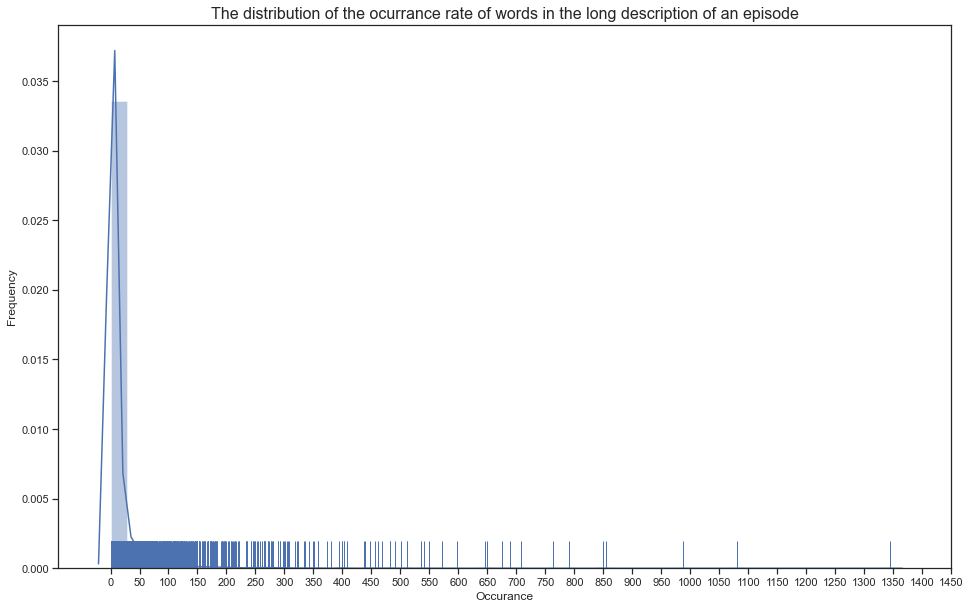

In [128]:
sns.distplot(list(Counter(desc_all_words).values()), rug=True)
plt.title("The distribution of the ocurrance rate of words in the long description of an episode",size=16)
plt.xlabel("Occurance")
plt.ylabel("Frequency")
plt.xticks(ticks=range(0,1500,50))
plt.show()

For the short description, these are the most common and least common words: 

In [129]:
short_all_words = []
for desc in df['short_desc']:
    for word in desc:
        short_all_words.append(word)

In [130]:
print("There is a total of {} unique words in the log description of all episodes".format(len(set(short_all_words))))

There is a total of 3915 unique words in the log description of all episodes


The 50 most common words are:

In [131]:
Counter(short_all_words).most_common(50)

[('get', 187),
 ('becom', 132),
 ('new', 125),
 ('take', 112),
 ('famili', 109),
 ('find', 102),
 ('meanwhil', 100),
 ('make', 92),
 ('school', 83),
 ('discov', 80),
 ('tri', 80),
 ('show', 75),
 ('help', 66),
 ('one', 66),
 ('town', 61),
 ('plan', 59),
 ('name', 59),
 ('start', 57),
 ('goe', 57),
 ('turn', 55),
 ('back', 54),
 ('day', 51),
 ('friend', 51),
 ('end', 50),
 ('howev', 50),
 ('give', 48),
 ('hous', 44),
 ('see', 43),
 ('two', 42),
 ('plant', 41),
 ('work', 41),
 ('tell', 41),
 ('time', 41),
 ('home', 40),
 ('like', 40),
 ('want', 39),
 ('win', 38),
 ('life', 37),
 ('power', 37),
 ('realiz', 37),
 ('littl', 36),
 ('love', 35),
 ('father', 35),
 ('call', 35),
 ('grampa', 34),
 ('soon', 34),
 ('boy', 34),
 ('come', 34),
 ('save', 33),
 ('first', 33)]

and the 50 most uncommon words are:

In [132]:
Counter(short_all_words).most_common()[:-50-1:-1]

[('trio', 1),
 ('fend', 1),
 ('freshen', 1),
 ('taxi', 1),
 ('often', 1),
 ('passeng', 1),
 ('paid', 1),
 ('grill', 1),
 ('smiley', 1),
 ('rehears', 1),
 ('chore', 1),
 ('dib', 1),
 ('overboard', 1),
 ('revolution', 1),
 ('elon', 1),
 ('breakout', 1),
 ('modest', 1),
 ('guitar', 1),
 ('mid', 1),
 ('mess', 1),
 ('crew', 1),
 ('catastroph', 1),
 ('ooz', 1),
 ('rabbit', 1),
 ('germ', 1),
 ('capsul', 1),
 ('aback', 1),
 ('frack', 1),
 ('assemblywoman', 1),
 ('symbol', 1),
 ('arama', 1),
 ('transport', 1),
 ('resolv', 1),
 ('disrespect', 1),
 ('whether', 1),
 ('reason', 1),
 ('juli', 1),
 ('frontrunn', 1),
 ('recant', 1),
 ('either', 1),
 ('lego', 1),
 ('thoroughbr', 1),
 ('conceiv', 1),
 ('voodoo', 1),
 ('healthi', 1),
 ('preach', 1),
 ('appreci', 1),
 ('chemic', 1),
 ('scientist', 1),
 ('manga', 1)]

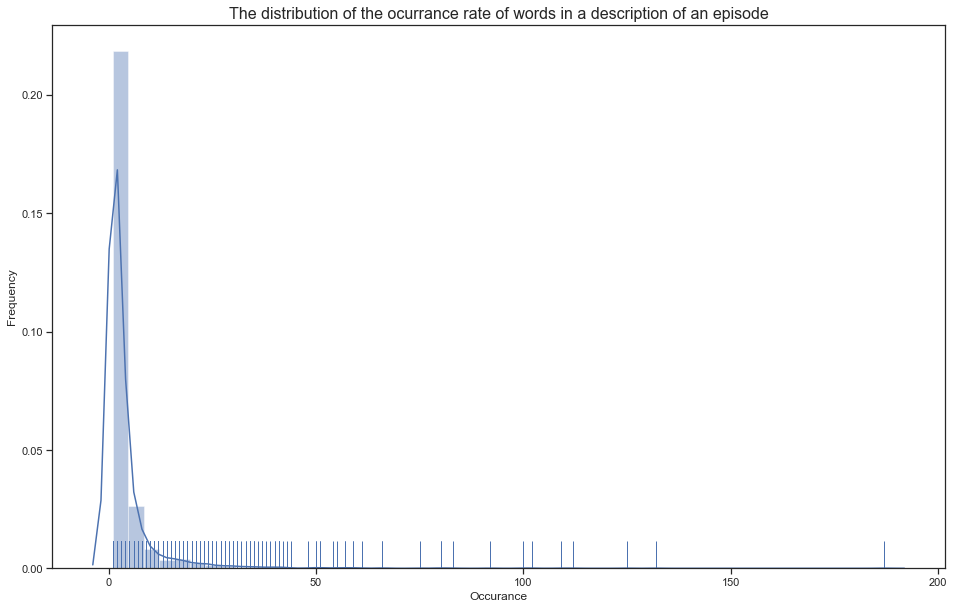

In [133]:
sns.distplot(list(Counter(short_all_words).values()), rug=True)
plt.title("The distribution of the ocurrance rate of words in a description of an episode",size=16)
plt.xlabel("Occurance")
plt.ylabel("Frequency")
plt.xticks(ticks=range(0,250,50))
plt.show()

For the scripts, these are the occurance frequencies: 

In [134]:
script_all_words = []
for script in df['script']:
    for word in script:
        script_all_words.append(word)

In [135]:
print("There is a total of {} unique words in the scripts of all episodes".format(len(set(script_all_words))))

There is a total of 27305 unique words in the scripts of all episodes


In [136]:
Counter(script_all_words).most_common(50)

[('well', 7084),
 ('like', 6309),
 ('get', 6102),
 ('one', 5122),
 ('know', 4998),
 ('that', 4503),
 ('hey', 4359),
 ('right', 4136),
 ('look', 3741),
 ('got', 3729),
 ('want', 3582),
 ('let', 3292),
 ('think', 3271),
 ('ill', 3210),
 ('come', 3200),
 ('see', 3164),
 ('good', 3149),
 ('say', 3004),
 ('make', 2854),
 ('time', 2823),
 ('take', 2784),
 ('man', 2781),
 ('cant', 2697),
 ('dad', 2658),
 ('gonna', 2636),
 ('back', 2618),
 ('littl', 2589),
 ('ive', 2363),
 ('could', 2354),
 ('never', 2281),
 ('love', 2275),
 ('boy', 2120),
 ('kid', 2109),
 ('would', 2018),
 ('hes', 2018),
 ('need', 1978),
 ('realli', 1956),
 ('thank', 1949),
 ('day', 1893),
 ('way', 1874),
 ('two', 1845),
 ('go', 1829),
 ('there', 1808),
 ('tell', 1744),
 ('give', 1736),
 ('guy', 1728),
 ('call', 1637),
 ('peopl', 1592),
 ('work', 1570),
 ('sorri', 1564)]

In [137]:
Counter(script_all_words).most_common()[:-50-1:-1]

[('scath', 1),
 ('unscath', 1),
 ('belladonna', 1),
 ('asphodel', 1),
 ('baptize', 1),
 ('garita', 1),
 ('tantric', 1),
 ('tonsillectomi', 1),
 ('hanuman', 1),
 ('saluki', 1),
 ('linkedin', 1),
 ('wiggin', 1),
 ('albeit', 1),
 ('dopey', 1),
 ('grohl', 1),
 ('acheb', 1),
 ('chinua', 1),
 ('pernt', 1),
 ('elocut', 1),
 ('vehement', 1),
 ('kemi', 1),
 ('arimasen', 1),
 ('waked', 1),
 ('suru', 1),
 ('koji', 1),
 ('watashi', 1),
 ('presumir', 1),
 ('refiero', 1),
 ('montrer', 1),
 ('veux', 1),
 ('mostrar', 1),
 ('dizer', 1),
 ('quero', 1),
 ('não', 1),
 ('concubin', 1),
 ('roxburi', 1),
 ('incompetenthom', 1),
 ('harshest', 1),
 ('orangewood', 1),
 ('bison', 1),
 ('steno', 1),
 ('slingin', 1),
 ('notif', 1),
 ('coq', 1),
 ('cru', 1),
 ('marriot', 1),
 ('lyft', 1),
 ('über', 1),
 ('nrc', 1),
 ('checkerboard', 1)]

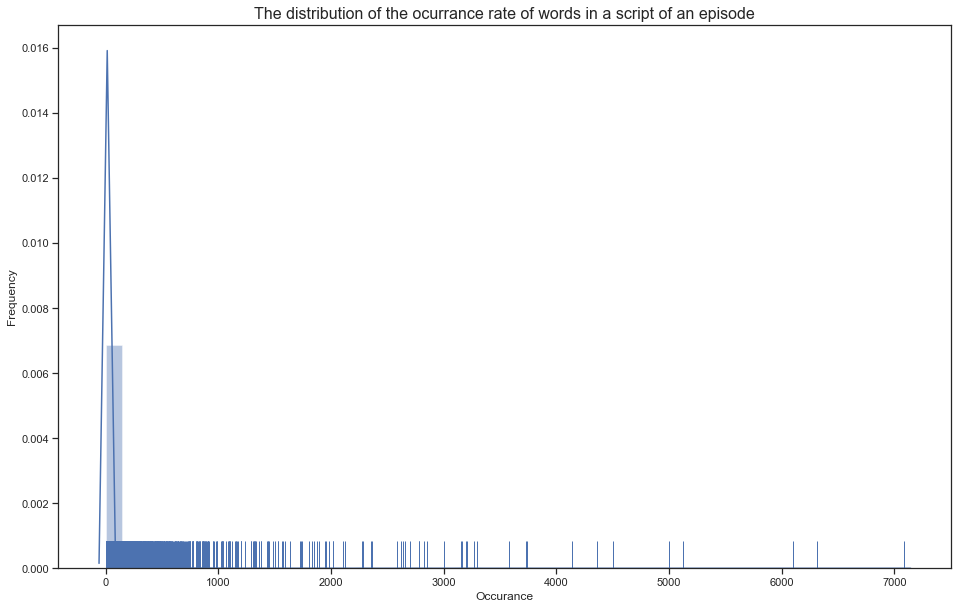

In [138]:
sns.distplot(list(Counter(script_all_words).values()), rug=True)
plt.title("The distribution of the ocurrance rate of words in a script of an episode",size=16)
plt.xlabel("Occurance")
plt.ylabel("Frequency")
plt.show()

After looking at the distribution of how often unique words occur in the long description and short description of episodes, words with a very high frequency and a very low frequency were removed from each episodes description.

For the long description, words occuring more than 250 times or less than 20 times will be removed. 

For the short description, words occuring less than 5 times or more than 100 times will be removed. 

In [139]:
desc_words_to_remove = list(dict(Counter(desc_all_words).most_common(20)).keys()) + list(dict(Counter(desc_all_words).most_common()[:-500:-1]).keys())

In [140]:
short_desc_words_to_remove = list(dict(Counter(short_all_words).most_common(20)).keys()) + list(dict(Counter(short_all_words).most_common()[:-400:-1]).keys())

In [141]:
script_words_to_remove = list(dict(Counter(script_all_words).most_common(20)).keys()) + list(dict(Counter(script_all_words).most_common()[:-5000:-1]).keys())

In [142]:
def remove_high_lo_freq(original_words, words_to_remove):
    for word in words_to_remove:
        while word in original_words:
            original_words.remove(word)
    return original_words

In [143]:
df['desc'] = df['desc'].apply(lambda x: remove_high_lo_freq(x, desc_words_to_remove))

In [144]:
df['short_desc'] = df['short_desc'].apply(lambda x: remove_high_lo_freq(x, short_desc_words_to_remove))

In [145]:
df['script'] = df['script'].apply(lambda x: remove_high_lo_freq(x, script_words_to_remove))

In [146]:
df['desc_len'] = df['desc'].apply(lambda x: len(x))
df['short_desc_len'] = df['short_desc'].apply(lambda x: len(x))
df['script_len'] = df['script'].apply(lambda x: len(x))

In [43]:
desc_all_words = []
for desc in df['desc']:
    for word in desc:
        desc_all_words.append(word)
        
Counter(desc_all_words).most_common(10)

[("'", 188070),
 (',', 93467),
 (' ', 93467),
 ('e', 53054),
 ('r', 40432),
 ('a', 39564),
 ('t', 37274),
 ('i', 35175),
 ('o', 34614),
 ('n', 30330)]

In [148]:
short_all_words = []
for desc in df['short_desc']:
    for word in desc:
        short_all_words.append(word)
        
Counter(short_all_words).most_common(10)

[('back', 54),
 ('day', 51),
 ('friend', 51),
 ('end', 50),
 ('howev', 50),
 ('give', 48),
 ('hous', 44),
 ('see', 43),
 ('two', 42),
 ('plant', 41)]

In [149]:
script_all_words = []
for script in df['script']:
    for word in script:
        script_all_words.append(word)
        
Counter(script_all_words).most_common(10)

[('take', 2784),
 ('man', 2781),
 ('cant', 2697),
 ('dad', 2658),
 ('gonna', 2636),
 ('back', 2618),
 ('littl', 2589),
 ('ive', 2363),
 ('could', 2354),
 ('never', 2281)]

In [150]:
df['desc_string'] = df['desc'].apply(lambda x: ' '.join(x))
df['short_desc_string'] = df['short_desc'].apply(lambda x: ' '.join(x))
df['script_string'] = df['script'].apply(lambda x: ' '.join(x))

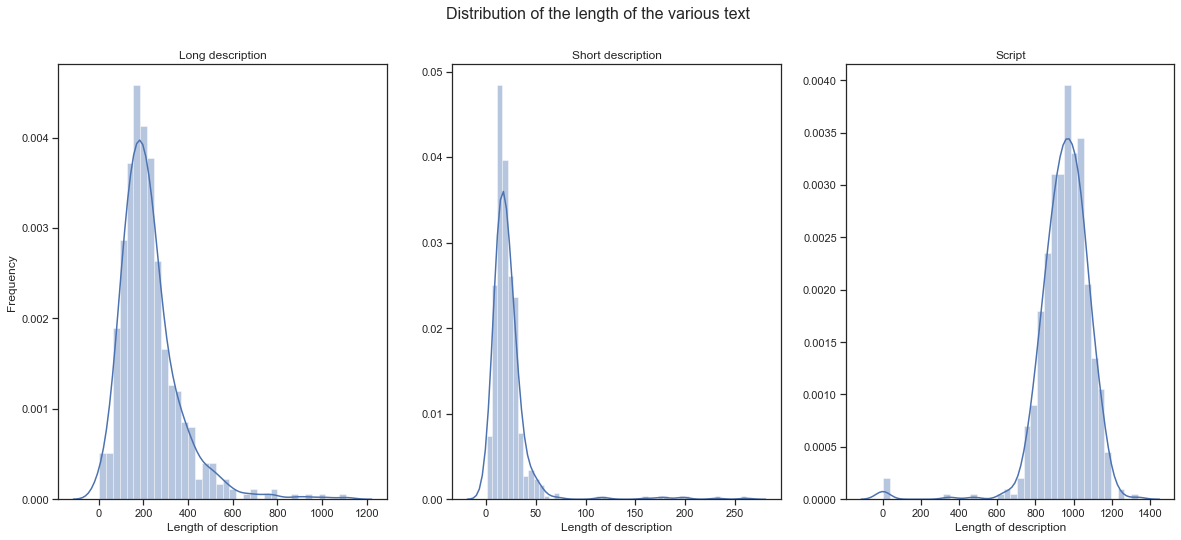

In [151]:
°1q


In [152]:
#df.to_csv('data_final_3.csv')

In [153]:
#df = pd.read_csv('data_final_3.csv')

In [2]:
df = pd.read_csv('data_final_4.csv')

# Topic modeling using NMF 

In [3]:
docs = list(df['desc_string'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from wordcloud import WordCloud
import random

In [5]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(docs)

In [6]:
inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

In [7]:
print("Total amount of words in vocabulary:", len(vectorizer.vocabulary_))
print("Number of documents: ", len(docs))

Total amount of words in vocabulary: 2704
Number of documents:  568


In [8]:
def color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(194, 78%%, %d%%)" % random.randint(30, 55)

In [9]:
n_components = 6
nmf = NMF(n_components=n_components, init='random')
W = nmf.fit_transform(X)

Topic 1 - top words:  plant friend job feel love parti class game learn date


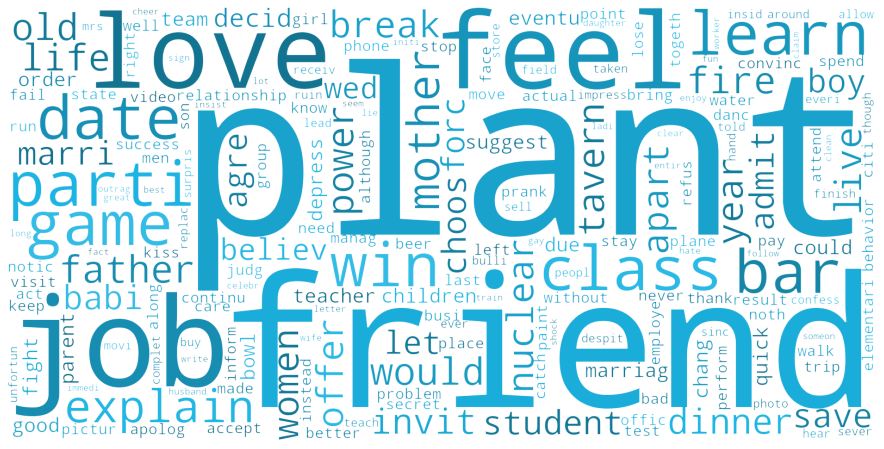

Topic 2 - top words:  grampa retir bea zelda fish castl drug wrestl elder effect


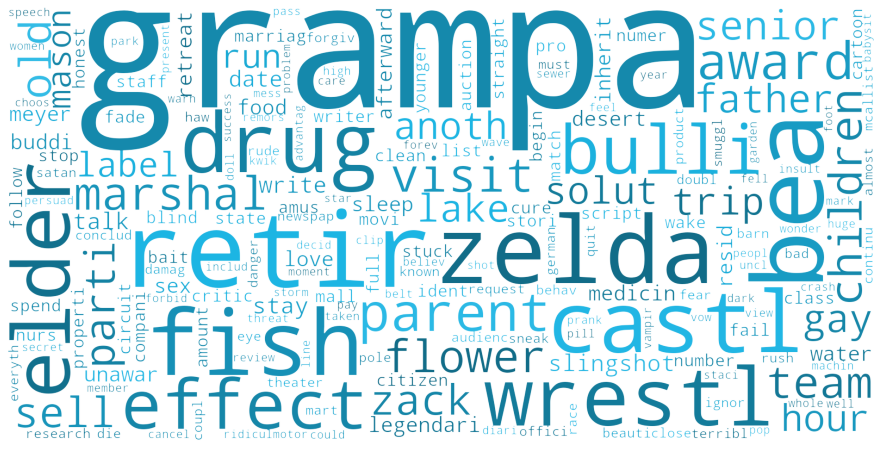

Topic 3 - top words:  santa littl dog christma hound present strangl train mall mitchel


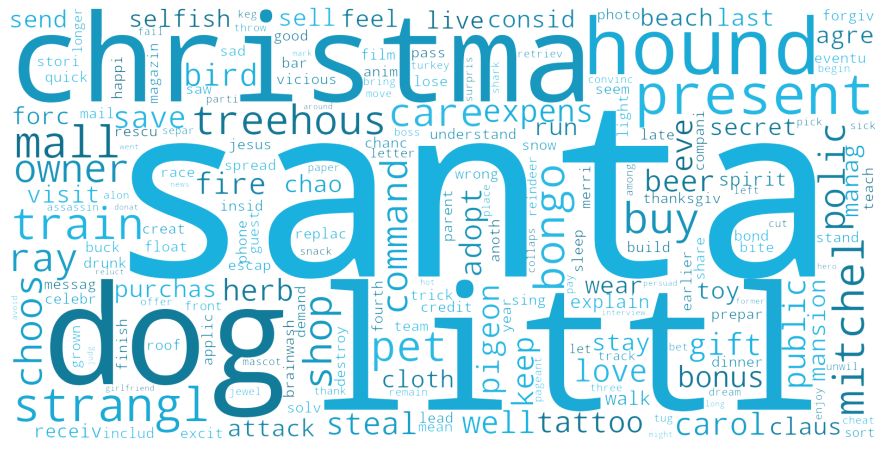

Topic 4 - top words:  church parodi chief god stori shoot peopl camp appear hair


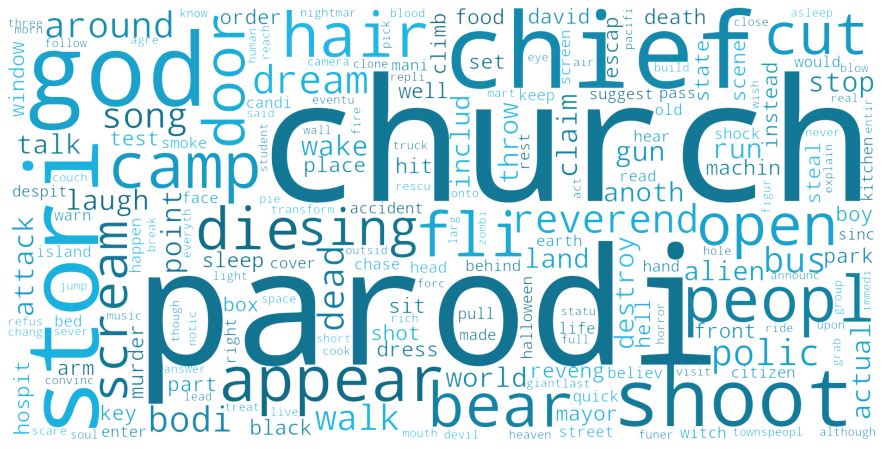

Topic 5 - top words:  book guy movi store film publish charact write mel role


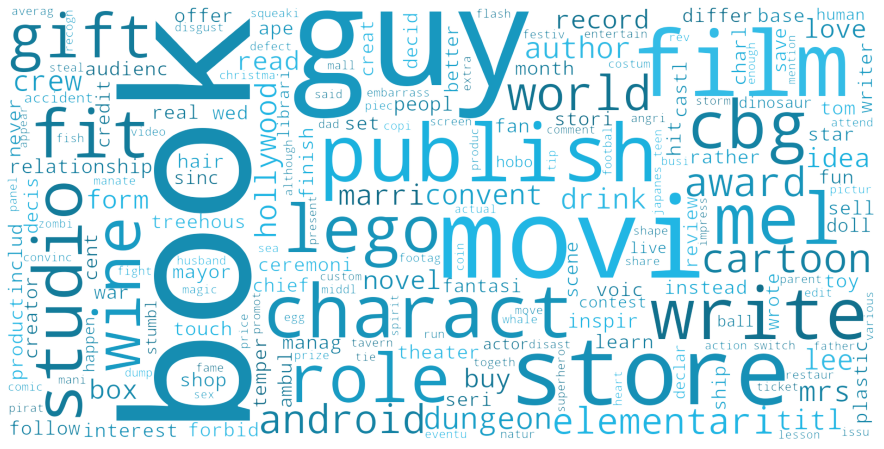

Topic 6 - top words:  fat mobster mob truffl gun mafia gang dan miss busi


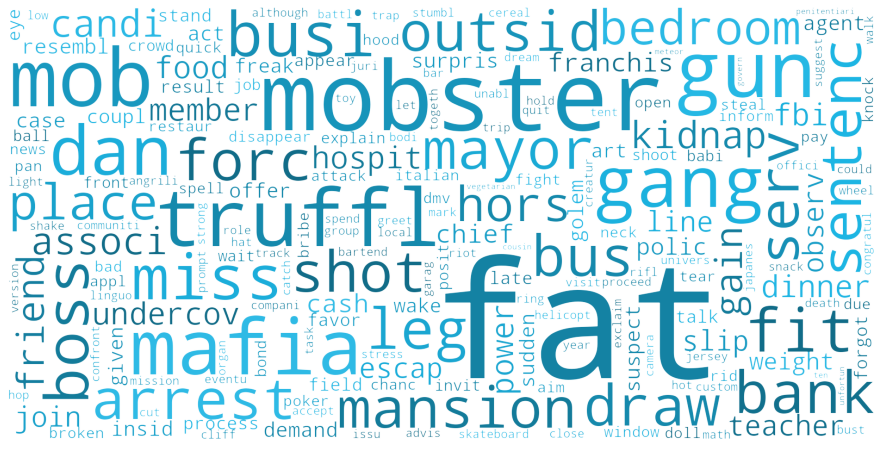

In [10]:
feature_names = []
for i in range(max(inv_vocab.keys())+1):
    feature_names.append(inv_vocab[i])
n_top_words = 10
SIZE = 100000
for topic_idx, topic in enumerate(nmf.components_):
    top = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(f"Topic {topic_idx+1} - top words: ", top)
    freqDict = {}
    for i in range(max(inv_vocab.keys())):
        freqDict[feature_names[i]] = int(topic[i]*SIZE)
    wc = WordCloud(width=1600, height=800, background_color="rgba(255, 255, 255, 0)", mode="RGBA")
    wc.generate_from_frequencies(freqDict)

    plt.figure(figsize=(20,8))
    plt.imshow(wc.recolor(color_func=color_func, random_state=3), interpolation='bilinear')
    plt.axis("off")
    plt.show()

In order to represent the uniqueness of each episode and make the *textual data* more descriptive, *TF-IDF analysis* was considered. However, David M. Blei argues that LDA addresses the shortcomings of the TF-IDF analysis and leaves that approach behind [[REF]](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf). Thus, we decided against using TF-IDF analysis for our model. 

##  4. Descriptive Stats <a class="anchor" id="four"></a>

The final data set is comprised of 600 rows where each row represents an episode of *The Simpsons*, and 13 feature columns. Each episode gets an overall rating between 0.0 and 10.0, although the minimum and maximum ratings in this dataset are $3.9$ and $9.3$ respectively. 

Each episode (row) has a feature called `desc` which holds the words used to describe the episode thoroughly, and a column called `short_desc` which represent a shortened description found on each episode's wiki page. 

In [11]:
df.shape

(568, 19)

The following tables show some basic stats about the data set.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         568 non-null    int64  
 1   no_overall         568 non-null    int64  
 2   season             568 non-null    int64  
 3   no_in_season       568 non-null    int64  
 4   episode_name       568 non-null    object 
 5   mil_viewers        568 non-null    float64
 6   rating             568 non-null    float64
 7   year               568 non-null    int64  
 8   month              568 non-null    int64  
 9   day                568 non-null    int64  
 10  desc               568 non-null    object 
 11  desc_len           568 non-null    int64  
 12  short_desc         568 non-null    object 
 13  short_desc_len     568 non-null    int64  
 14  script             568 non-null    object 
 15  script_len         568 non-null    int64  
 16  desc_string        568 non

In [13]:
df.describe()

Unnamed: 0  no_overall      season  no_in_season  mil_viewers  \
count  568.000000  568.000000  568.000000    568.000000   568.000000   
mean   283.500000  284.500000   13.376761     11.568662    12.282746   
std    164.111751  164.111751    7.327965      6.517284     6.290557   
min      0.000000    1.000000    1.000000      1.000000     2.670000   
25%    141.750000  142.750000    7.000000      6.000000     7.600000   
50%    283.500000  284.500000   13.000000     11.000000    10.600000   
75%    425.250000  426.250000   20.000000     17.000000    15.500000   
max    567.000000  568.000000   26.000000     25.000000    33.600000   

           rating         year       month         day    desc_len  \
count  568.000000   568.000000  568.000000  568.000000  568.000000   
mean     7.354930  2001.991197    6.031690   15.000000  165.554577   
std      0.817647     7.345703    3.946608    8.387864  100.082737   
min      3.900000  1989.000000    1.000000    1.000000    2.000000   
25%      6.800000  1996.000000    3.000000    8.000000  103.000000   
50%      7.200000  2002.000000    5.000000   15.000000  146.000000   
75%      8.000000  2008.000000   11.000000   21.000000  199.250000   
max      9.300000  2015.000000   12.000000   31.000000  783.000000   

       short_desc_len  script_len  
count      568.000000  568.000000  
mean        17.702465  530.264085  
std         18.206958   77.566543  
min          0.000000    0.000000  
25%         10.000000  491.000000  
50%         14.000000  538.000000  
75%         21.000000  576.000000  
max        183.000000  766.000000

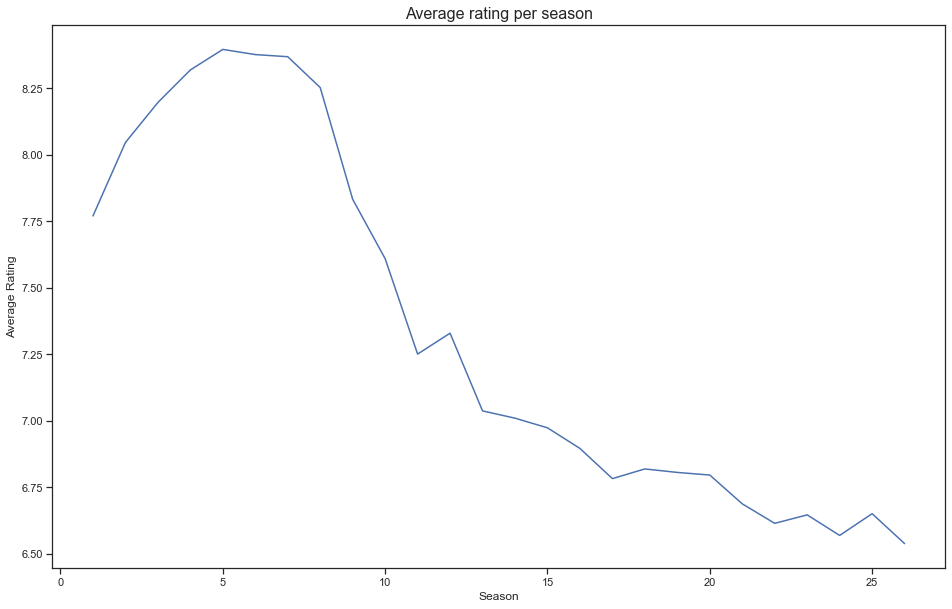

In [14]:
sns.lineplot(x='season',y='rating',data=df.groupby('season').mean()['rating'].reset_index())
plt.title("Average rating per season", size=16)
plt.xlabel("Season")
plt.ylabel("Average Rating")
plt.show()

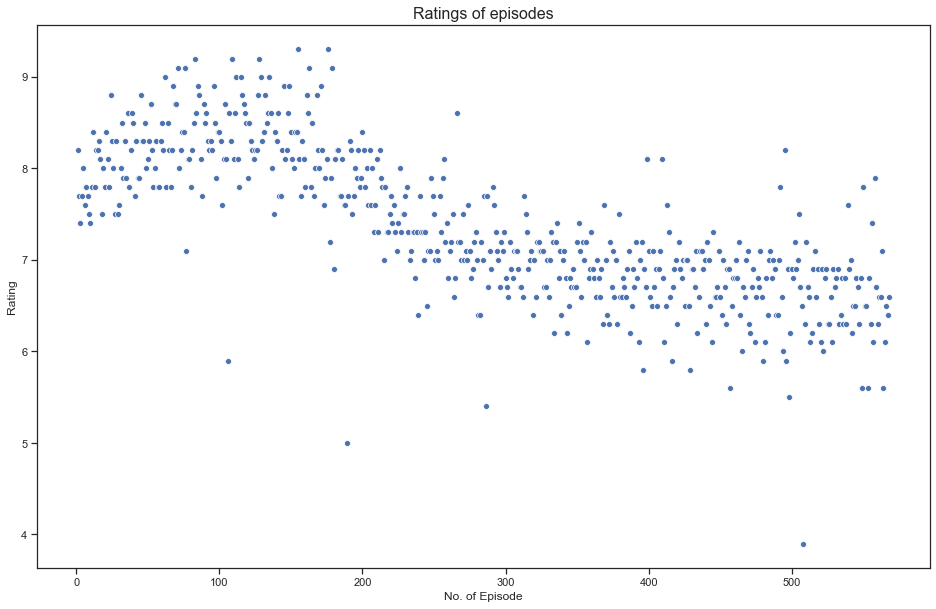

In [15]:
sns.scatterplot(x='no_overall',y='rating',data=df)
plt.title("Ratings of episodes", size=16)
plt.xlabel("No. of Episode")
plt.ylabel("Rating")
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


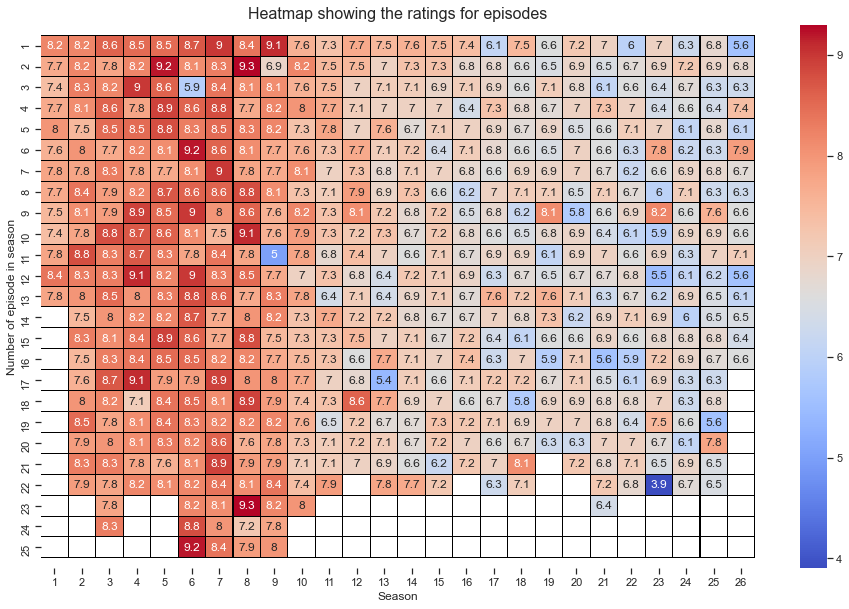

In [16]:
ax = sns.heatmap(df[['rating','no_in_season','season']].pivot_table(columns='season',index='no_in_season',values='rating'),
                 annot=True,
                 cmap='coolwarm',
                linewidth=0.05,
                linecolor='black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Heatmap showing the ratings for episodes", size=16)
plt.ylabel("Number of episode in season")
plt.xlabel("Season")
plt.show()

The past three plots visualize the decline over the years. While each season has its lowpoints, the quality (rating) of episodes has been going down over the past years. 

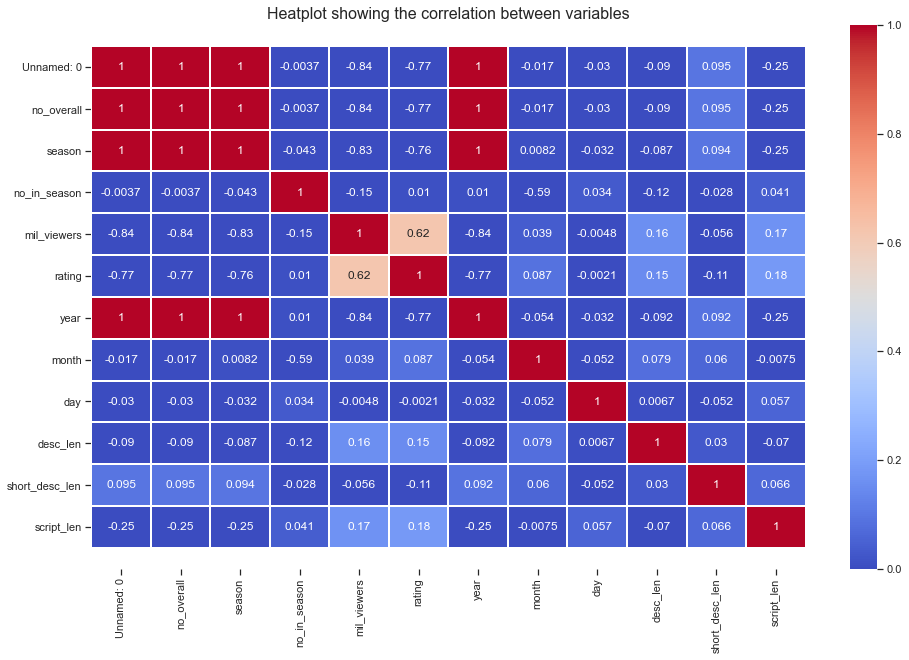

In [17]:
ax = sns.heatmap(df.corr(), annot=True,vmin=0.0, vmax=1.0, cmap='coolwarm',linewidths=1) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Heatplot showing the correlation between variables", size=16)
plt.show()

There seems to be some correlation between how many are watching the episode and how highly it is rated. 

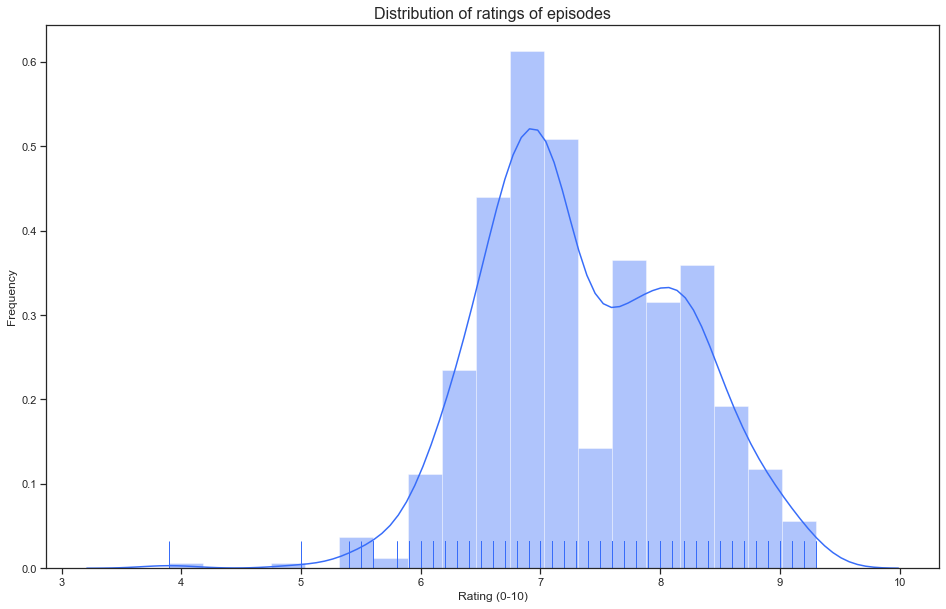

In [18]:
sns.set_palette('rainbow')
sns.distplot(df['rating'], rug=True)
plt.title("Distribution of ratings of episodes", size=16)
plt.xlabel("Rating (0-10)")
plt.ylabel("Frequency")
plt.show()

Most episodes are scoring a rating between 6 and 8.5

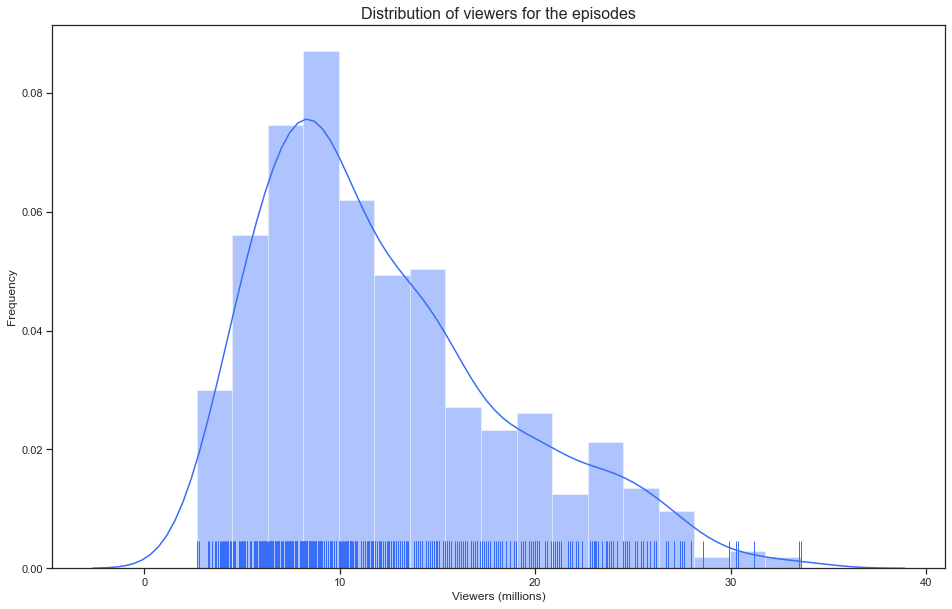

In [19]:
sns.distplot(df['mil_viewers'], rug=True)
plt.title("Distribution of viewers for the episodes", size=16)
plt.xlabel("Viewers (millions)")
plt.ylabel("Frequency")
plt.show()

Most episodes have around 5-15 million viewers. 

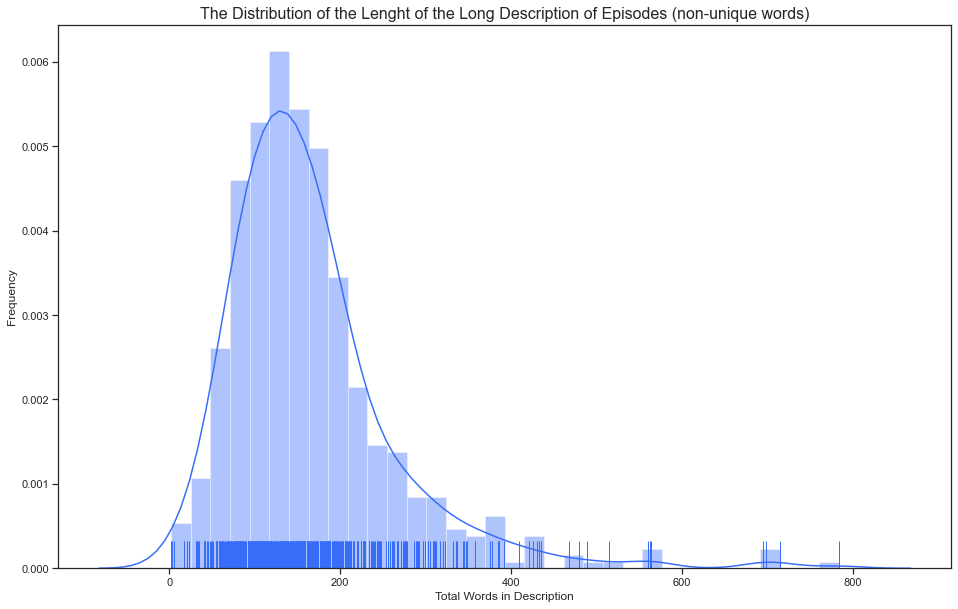

In [20]:
sns.distplot(df[df['desc_len']>0]['desc_len'], rug=True)
plt.title("The Distribution of the Lenght of the Long Description of Episodes (non-unique words)", size=16)
plt.xlabel("Total Words in Description")
plt.ylabel("Frequency")
plt.show()

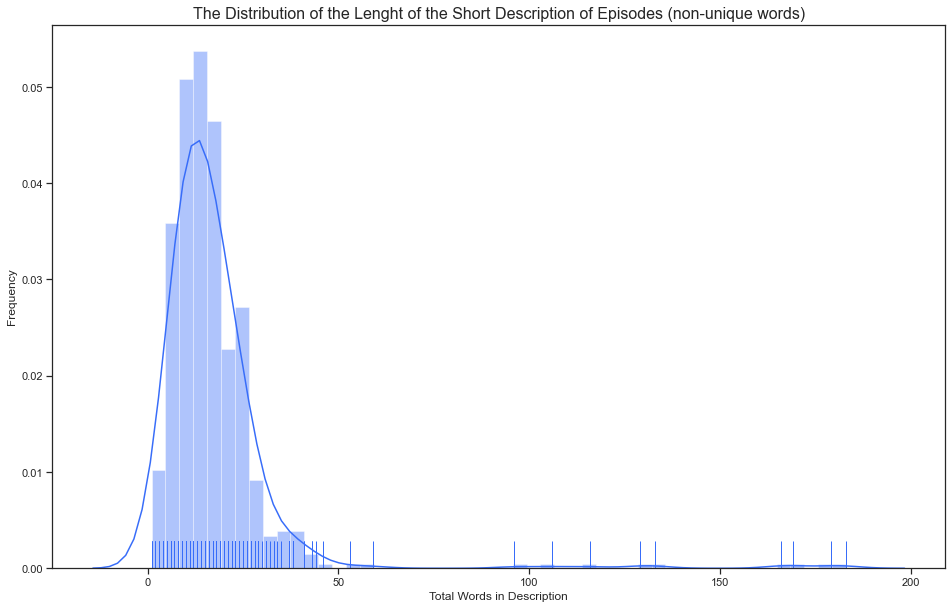

In [21]:
sns.distplot(df[df['short_desc_len']>0]['short_desc_len'], rug=True)
plt.title("The Distribution of the Lenght of the Short Description of Episodes (non-unique words)", size=16)
plt.xlabel("Total Words in Description")
plt.ylabel("Frequency")
plt.show()

# 5. Linear Regression - For comparison <a class="anchor" id="reg"></a>

In order to see if the new topical model is more accurate than a normal linear regression model, a simple linear regression model was created in order to try and predict the rating of an episode. 

In [3]:
df.columns

Index(['Unnamed: 0', 'no_overall', 'season', 'no_in_season', 'episode_name',
       'mil_viewers', 'rating', 'year', 'month', 'day', 'desc', 'desc_len',
       'short_desc', 'short_desc_len', 'script', 'script_len', 'desc_string',
       'short_desc_string', 'script_string'],
      dtype='object')

In [23]:
X = df[['no_overall','no_in_season','season','mil_viewers']].values

In [24]:
y = df['rating'].values

In [25]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [26]:
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [28]:
lm = LinearRegression()

In [29]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
predictions = lm.predict(X_test)

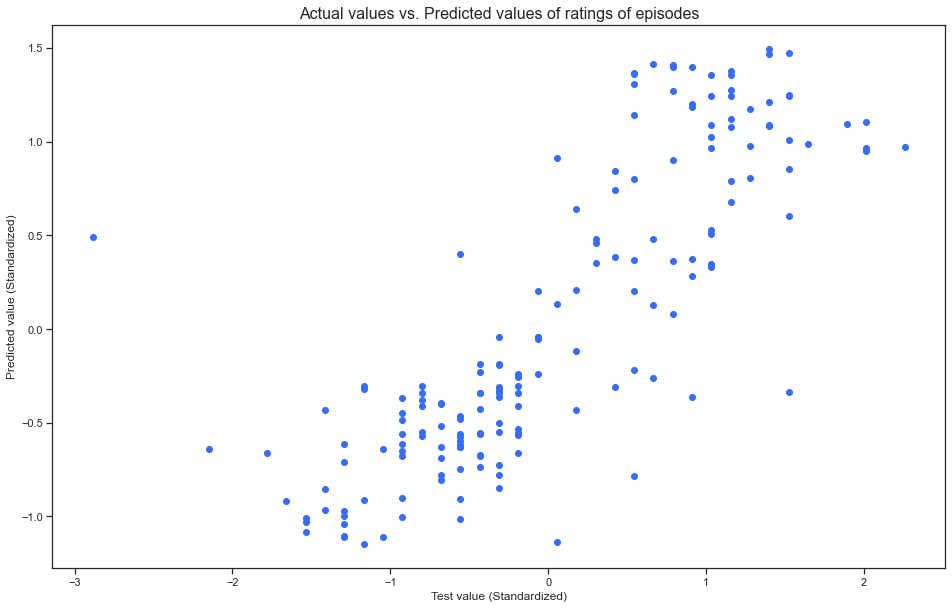

In [31]:
plt.scatter(y_test,predictions)
plt.title("Actual values vs. Predicted values of ratings of episodes", size=16)
plt.xlabel("Test value (Standardized)")
plt.ylabel("Predicted value (Standardized)")
plt.show()

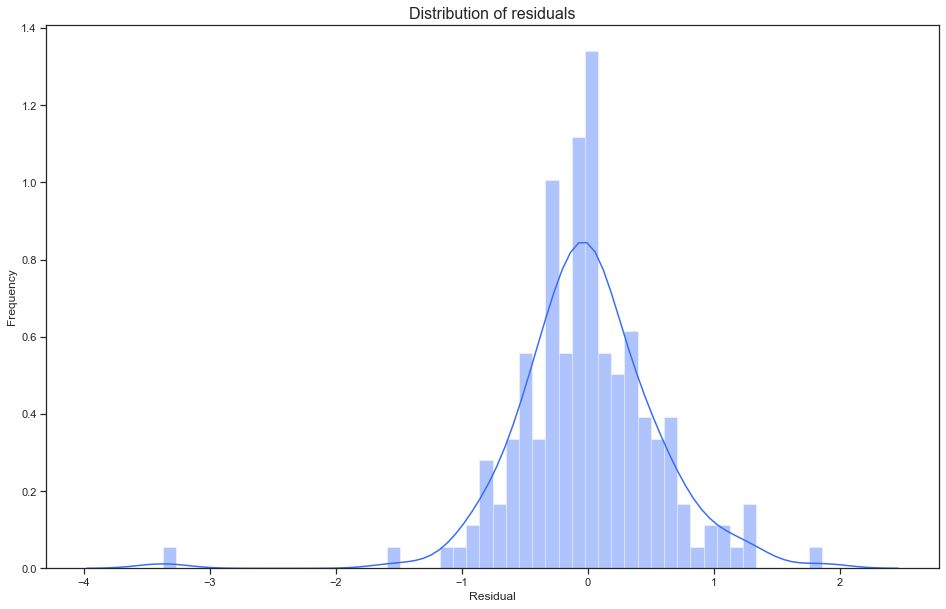

In [32]:
sns.distplot((y_test-predictions),bins=50);
plt.title("Distribution of residuals", size=16)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [34]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.3944057871576784
MSE: 0.3184096580070115
RMSE: 0.5642779970962996


From this it can be seen that creating a linear regression model in order to predict an episode's rating from other features is somewhat achievable.

# 6. Generative Story & PGM <a class="anchor" id="six"></a>

As we will deploy LDA for our topic model, the generative story for the inference of topics will follow the same generative story LDA follows. Here, we have changed the wording to fit our project. The following will be the generative story our model will follow: 

1. For each topic $k \in \{1,2,...,K\}$ where $K$ is the assumed total number of topics, there is a vector of $C$ words, $\phi_k$, such that $p(\theta_k|\beta) = \text{Dir}(\beta)$

2. For each document (*episode*) $i$:

>a) There is a vector of $K$ topics, $\theta_i$, such that $p(\theta_i|\alpha) = \text{Dir}(\alpha)$ 
    
>b) For each of the words $j$ in each episode $i$, where $j\in \{1,2,...,||w_i||\}$, we have
    
>>i) A **topic assignment** $z_{i,j} \in \{1,2,...,K\}$ such that $p(z_{i,j}|\theta_i) = \text{Cat}(\theta_i)$
    
>>ii) A **word** $w_{i,j}$ such that $p(w_{i,j}|\phi_{z_{i,j}}) = \text{Cat}(\phi_{z_{i,j}})$

What this means is that each episode will get assigned topic proportions and each topic will get assigned word proportions. 


### First version of our PGM

![title](lda_pgm_mkk.png)

In [4]:
topic_columns = ['topic '+str(k) for k in range(1,33)]

In [5]:
topic_columns

['topic 1',
 'topic 2',
 'topic 3',
 'topic 4',
 'topic 5',
 'topic 6',
 'topic 7',
 'topic 8',
 'topic 9',
 'topic 10',
 'topic 11',
 'topic 12',
 'topic 13',
 'topic 14',
 'topic 15',
 'topic 16',
 'topic 17',
 'topic 18',
 'topic 19',
 'topic 20',
 'topic 21',
 'topic 22',
 'topic 23',
 'topic 24',
 'topic 25',
 'topic 26',
 'topic 27',
 'topic 28',
 'topic 29',
 'topic 30',
 'topic 31',
 'topic 32']

In [6]:
df_topics = pd.read_csv('topic_df.csv')

FileNotFoundError: [Errno 2] File topic_df.csv does not exist: 'topic_df.csv'

The first version of our PGM is shown here above. We plan to build on top of it, create a dynamic topic model with inspo from [here](https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf)

## Continuous Time Dynamic Topic Model


>"LDA is a very powerful technique for the qualitative analysis of large corpora because of its highly interpretable topics, and it is also useful for dimensionality reduction as it transforms sparse document-term matrices into fixed low dimensional document-topic matrices. However, LDA ignores the temporal aspect present in many document collections." - [source](https://towardsdatascience.com/exploring-the-un-general-debates-with-dynamic-topic-models-72dc0e307696)

with great insporation from [here](https://arxiv.org/pdf/1206.3298.pdf) and [here](https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf)

![title](pgm_time.png)

Let $i, j (j>i>0)$, be two arbitarty time $indexes, s_i$ and $s_j$ be the time stamps, and $\Delta_{s_j,s_i}$ be the elapsed time between them.

1) For each topic $k$, 1$\leq$$k$$\leq$$K$,

* Draw $\beta_{0,k}$ $\sim$ $\mathcal{N}$( $m,v_{0}I$)


2) For document $d_t$ at time $s_t$ (t>0),
* For each topic $k$, 1$\leq k \leq K$,
    * From the Brownian motion model, draw 
    $\beta_{t,k}|\beta_{t-1,k}, s \sim \mathcal{N} (\beta_{t-1,k},v\Delta _{s_{t}}I)$
* Draw $\theta_{t} \sim$ Mult($\theta_{t}$) 
* For each word
    * Draw $z_{t,n} \sim $ Mult($\theta_t$)
    * Draw $w_{t,n} \sim $ Mult($\pi(\beta_{t,z_{t,n}}$) 


The evolution of the topic parameters $\beta_t$ is governed by Brownian motion. 

The variable $s_t$ is the observed time stamp of document $d_t$ 

# 7. Stan Model

### Full model, first version

In [7]:
LDA_STAN="""
data{
    int<lower=1> I; 
    int<lower=1> J[I];  // We mean J=||W_i||
    int<lower=2> K; // # of topics
    int<lower=2> C; 
    vector<lower=0>[K] alpha;
    vector<lower=0>[C] beta;
    int<lower=2> MAX_J;
    int W[I,MAX_J];
}

parameters{
    simplex[K] theta[I];
    simplex[C] phi[K];
}

model{
    for (k in 1:K)
        phi[k]~dirichlet(beta);
        
    for (i in 1:I){
        theta[i]~dirichlet(alpha);
        
        for (j in 1:J[i]){
                real gamma[K];
                for (k in 1:K)
                    // log(P(z = k | theta)) + log(P(W | phi, z = k)) 
                    gamma[k]=log(theta[i,k])+log(phi[k,W[i][j]]);
                
                target+=(log_sum_exp(gamma)); //likelihood
        }
    }
}

"""

I: number of documents (episodes)

In [8]:
I = len(df)
I

568

J = ||w_i|| : number of words in each episode

In [9]:
J = df['desc_len'].to_list()

In [10]:
K = 15

C: number of words in our dictionary

In [11]:
from ast import literal_eval
df['desc'] = df['desc'].apply(literal_eval)

In [12]:
desc_all_words = []
for desc in df['desc']:
    for word in desc:
        desc_all_words.append(word)
        
Counter(desc_all_words).most_common(10)

[('book', 250),
 ('run', 249),
 ('feel', 247),
 ('old', 246),
 ('littl', 245),
 ('would', 244),
 ('life', 236),
 ('explain', 235),
 ('peopl', 235),
 ('love', 233)]

In [13]:
dictionary = set(desc_all_words)
dictionary = list(dictionary)
C = len(dictionary)
C

2704

#### BOW 

In [14]:
df.desc

0      [snow, cover, street, late, christma, pageant,...
1      [live, effort, build, test, hate, game, cheat,...
2      [front, elementari, mrs, round, class, includ,...
3      [fight, long, quick, rush, break, bad, behavio...
4      [insid, kitchen, bake, cupcak, bring, cupcak, ...
                             ...                        
563    [backyard, elon, similar, capsul, elon, explai...
564    [vacat, explain, springfield, hall, anthem, se...
565    [assign, list, place, around, chore, sneak, ba...
566    [daughter, milk, leak, lunch, trade, chip, ful...
567    [chief, mistaken, deliv, militari, jet, pack, ...
Name: desc, Length: 568, dtype: object

In [15]:
#for rownumber in range(len(df.desc)):
#    df.desc[rownumber] = re.sub(r'[^\w]', ' ', df.desc[rownumber])
#    df.desc[rownumber] = df.desc[rownumber].split()
    
numbered_dic = {ni: indi for indi, ni in enumerate(dictionary)}

w = np.zeros((I, np.max(J)), dtype=int )
for i in range(I): # I = number of episodes
    for j in range(J[i]): # J = number of words per episode
        w[i,j] = numbered_dic.get(df.desc[i][j])

In [16]:
w

array([[1376, 2001, 1530, ...,    0,    0,    0],
       [2318, 1593,  633, ...,    0,    0,    0],
       [1661,   85, 1192, ...,    0,    0,    0],
       ...,
       [1261,  612,  159, ...,    0,    0,    0],
       [ 428,  430,  551, ...,    0,    0,    0],
       [2528, 1678, 1681, ...,    0,    0,    0]])

In [56]:
alpha = np.ones(K)
beta = np.ones(C)

In [57]:
print('I:',I)
print('J;',J)
print('K:',K)
print('C:',C)
print('alpha:',alpha)
print('beta',beta)
print('MAX_J',np.max(J))

I: 568
J; [695, 332, 392, 156, 203, 247, 273, 161, 276, 155, 120, 421, 335, 143, 268, 263, 224, 78, 122, 196, 126, 5, 562, 113, 151, 163, 152, 206, 79, 168, 124, 104, 159, 107, 94, 137, 564, 173, 138, 164, 90, 246, 151, 186, 80, 162, 220, 157, 209, 163, 278, 111, 310, 136, 32, 40, 183, 108, 74, 311, 156, 145, 194, 433, 136, 161, 104, 164, 168, 236, 357, 72, 277, 174, 219, 357, 98, 131, 289, 185, 88, 267, 131, 100, 42, 309, 92, 138, 68, 194, 56, 80, 92, 141, 278, 123, 124, 156, 76, 109, 203, 98, 118, 81, 131, 23, 182, 126, 698, 184, 98, 149, 69, 179, 61, 130, 159, 69, 120, 161, 271, 216, 100, 159, 202, 184, 117, 291, 467, 48, 256, 239, 292, 297, 58, 247, 187, 76, 375, 62, 106, 150, 101, 100, 117, 120, 56, 299, 489, 193, 182, 108, 233, 111, 2, 17, 92, 63, 139, 148, 229, 226, 65, 151, 109, 79, 82, 183, 141, 117, 176, 159, 195, 271, 98, 303, 212, 71, 276, 137, 208, 322, 125, 127, 110, 134, 168, 182, 154, 114, 191, 134, 55, 166, 156, 152, 123, 143, 84, 67, 130, 148, 93, 128, 159, 80, 347, 6

In [58]:
## Compile and collect data
sm = pystan.StanModel(model_code=LDA_STAN)
data={'I':I, 'J':J, 'K':K, 'C':C, 'alpha':alpha, 'beta':beta, 'MAX_J':np.max(J), 'W':w+1}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b976da1749d3b34919bedb3ec5dbdb4 NOW.


In [59]:
## Sample with VB
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

Extract results from STAN:

In [60]:
theta_hat = pystan_utils.vb_extract_variable(fit, "theta", var_type="matrix", dims=[I,K])
phi_hat = pystan_utils.vb_extract_variable(fit, "phi", var_type="matrix", dims=[K,C])

In [61]:
np.argmax(phi_hat, axis=0)

array([10,  4,  6, ..., 12, 11, 11])

In [62]:
print(K)

15


In [63]:
print(np.shape(theta_hat))
print(np.shape(phi_hat))

(568, 15)
(15, 2704)


In [64]:
theta_hat

array([[0.0070813 , 0.00326325, 0.00511252, ..., 0.00531514, 0.00659827,
        0.00667784],
       [0.03702073, 0.00561465, 0.00798461, ..., 0.01031465, 0.01156071,
        0.01315225],
       [0.04135469, 0.01354007, 0.2723761 , ..., 0.01377688, 0.01357634,
        0.0116572 ],
       ...,
       [0.0546426 , 0.0170429 , 0.11836347, ..., 0.03583939, 0.04625519,
        0.04747391],
       [0.35098601, 0.01329622, 0.02096744, ..., 0.03596238, 0.05721115,
        0.04107051],
       [0.10500588, 0.01434919, 0.02913105, ..., 0.02433818, 0.02918275,
        0.03075504]])

In [65]:
def print_lda_results(theta, phi, K, dictionary):
    topic_columns = ['topic '+str(k+1) for k in range(K)]
    df_theta = pd.DataFrame(theta_hat, columns=topic_columns)
    df_phi = pd.DataFrame(phi, columns=dictionary)
    print("----- TOPICS ------")
    print("\n")
    for topic, words in df_phi.iterrows():
        topic_words = dict(words)
        sorted_words = {k: v for k, v in sorted(topic_words.items(), key=lambda item: item[1], reverse = True)}
        top_words = list(sorted_words.keys())[:8]
        print(f"Topic {topic+1}: {top_words}")
    print("\n")
    print("------ DOCUMENTS ------\n")
    print("\n")
    for document, topics in df_theta.iterrows():
        topic_props = dict(topics)
        sorted_topics = {k: v for k, v in sorted(topic_props.items(), key=lambda item: item[1], reverse = True)}
        top_topic = list(sorted_topics.keys())[0]
        next_topic = list(sorted_topics.keys())[1]
        print(f"--------------- Document {document+1}-------------------- \n{df.iloc[document]['desc']}\n{top_topic} = {sorted_topics[top_topic]}\n{next_topic} = {sorted_topics[next_topic]}\n")

In [66]:
print_lda_results(theta_hat, phi_hat, K, dictionary)

----- TOPICS ------


Topic 1: ['game', 'boy', 'love', 'parent', 'keep', 'babi', 'place', 'fight']
Topic 2: ['grampa', 'movi', 'film', 'award', 'fish', 'thus', 'win', 'mel']
Topic 3: ['bulli', 'bus', 'run', 'break', 'beer', 'crowd', 'chief', 'old']
Topic 4: ['sing', 'song', 'place', 'group', 'danc', 'read', 'perform', 'popular']
Topic 5: ['order', 'would', 'bar', 'live', 'break', 'actual', 'father', 'peopl']
Topic 6: ['littl', 'santa', 'parti', 'christma', 'dog', 'love', 'wed', 'year']
Topic 7: ['plant', 'nuclear', 'power', 'camp', 'fire', 'job', 'old', 'employe']
Topic 8: ['fat', 'student', 'test', 'monorail', 'teacher', 'class', 'bad', 'mrs']
Topic 9: ['book', 'appear', 'parodi', 'stori', 'chief', 'box', 'hair', 'guy']
Topic 10: ['paint', 'keep', 'color', 'art', 'lead', 'real', 'role', 'museum']
Topic 11: ['mart', 'kwik', 'buy', 'shelbyvill', 'sell', 'thus', 'funer', 'soul']
Topic 12: ['herb', 'elon', 'thus', 'brother', 'great', 'box', 'keep', 'compani']
Topic 13: ['walt', 'state', '


--------------- Document 33-------------------- 
['reverend', 'grampa', 'retreat', 'held', 'lake', 'spend', 'fish', 'though', 'spent', 'resolv', 'differ', 'fish', 'sneak', 'fish', 'gear', 'besid', 'grampa', 'list', 'number', 'case', 'emerg', 'secret', 'number', 'grampa', 'hear', 'everyth', 'fine', 'retreat', 'learn', 'legendari', 'vow', 'catch', 'fish', 'decid', 'advantag', 'left', 'grampa', 'creat', 'list', 'food', 'cannot', 'lead', 'shop', 'trip', 'smoke', 'grampa', 'candi', 'ice', 'cream', 'item', 'grampa', 'burger', 'video', 'arcad', 'marriag', 'retreat', 'coupl', 'explain', 'fault', 'person', 'rev', 'problem', 'everyth', 'perfect', 'admit', 'everi', 'littl', 'thing', 'annoy', 'wish', 'would', 'least', 'interrupt', 'wait', 'done', 'list', 'long', 'talk', 'sever', 'hour', 'reverend', 'cancel', 'morn', 'sneak', 'fish', 'wake', 'catch', 'angri', 'would', 'choos', 'fish', 'marriag', 'messag', 'lost', 'walk', 'instead', 'agre', 'dock', 'abandon', 'fish', 'pole', 'pick', 'small', 'onto'


--------------- Document 196-------------------- 
['remot', 'control', 'inform', 'student', 'elementari', 'newli', 'open', 'wander', 'walk', 'exhibit', 'planet', 'process', 'push', 'giant', 'ear', 'gang', 'bulli', 'freed', 'center', 'employe', 'chief', 'observ', 'imagin', 'friend', 'arrang', 'spend', 'unhappi', 'arrang', 'exploit', 'chief', 'polic', 'master', 'key', 'open', 'door', 'thus', 'steal', 'key', 'sever', 'shop', 'encount', 'gang', 'boy', 'penitentiari', 'object', 'afraid', 'key', 'intend', 'without', 'bulli', 'made', 'feel', 'made', 'feel', 'hope', 'lost', 'remark', 'bore', 'bulli', 'toss', 'key', 'penitentiari', 'process', 'activ', 'old', 'electr', 'chair', 'melt', 'wed', 'cake', 'doll', 'afterward', 'learn', 'penitentiari', 'unawar', 'power', 'activ', 'mayor', 'electr', 'chair', 'public', 'unabl', 'warn', 'mayor', 'telephon', 'may', 'electrocut', 'point', 'probabl', 'figur', 'warn', 'mayor', 'launch', 'small', 'model', 'rocket', 'warn', 'messag', 'attach', 'aim', 'toward',

--------------- Document 238-------------------- 
['award', 'host', 'award', 'announc', 'award', 'die', 'heart', 'attack', 'stage', 'kiss', 'titl', 'pass', 'honor', 'prompt', 'clinic', 'choos', 'mansion', 'figur', 'employe', 'due', 'good', 'perform', 'live', 'king', 'told', 'situat', 'gone', 'parti', 'water', 'land', 'law', 'forgot', 'doctor', 'everyth', 'everi', 'singl', 'diseas', 'known', 'medicin', 'includ', 'sever', 'sinc', 'everyth', 'diseas', 'cancel', 'doctor', 'dozen', 'peopl', 'door', 'conclud', 'parti', 'boat', 'board', 'chines', 'pirat', 'ship', 'rob', 'crew', 'net', 'toss', 'mansion', 'peopl', 'bottom', 'peopl', 'top', 'ownership', 'lack', 'wealth', 'credit', 'peopl', 'although', 'feel', 'voic', 'actor', 'rich', 'except', 'poor']
topic 2 = 0.18752045932174893
topic 9 = 0.1844019532562809

--------------- Document 239-------------------- 
['elementari', 'prepar', 'big', 'perform', 'state', 'fair', 'suggest', 'old', 'song', 'perform', 'differ', 'song', 'jame', 'brown', 'live'


--------------- Document 254-------------------- 
['everybodi', 'els', 'receiv', 'mail', 'let', 'know', 'nuclear', 'plant', 'close', 'due', 'actual', 'accident', 'never', 'own', 'comput', 'feel', 'left', 'behind', 'decid', 'purchas', 'comput', 'buy', 'expens', 'store', 'thank', 'salesman', 'bring', 'quick', 'throw', 'trash', 'unabl', 'assassin', 'eventu', 'comput', 'liter', 'follow', 'creat', 'websit', 'fill', 'internet', 'borrow', 'site', 'danc', 'jesus', 'upset', 'nobodi', 'visit', 'site', 'suggest', 'offer', 'societi', 'need', 'dish', 'heard', 'repair', 'swim', 'pool', 'decid', 'creat', 'news', 'websit', 'could', 'protect', 'angri', 'citizen', 'may', 'write', 'subsequ', 'mayor', 'expos', 'repair', 'fund', 'hero', 'townspeopl', 'reward', 'sinc', 'know', 'person', 'quick', 'unveil', 'ident', 'win', 'prize', 'enough', 'peopl', 'lip', 'around', 'run', 'real', 'news', 'wild', 'stori', 'accus', 'wild', 'stori', 'state', 'flu', 'shot', 'given', 'form', 'mind', 'control', 'big', 'shop', 'r


--------------- Document 397-------------------- 
['follow', 'fals', 'advic', 'parent', 'magazin', 'pacifi', 'lead', 'destroy', 'insid', 'decid', 'pacifi', 'cannot', 'right', 'brand', 'cri', 'santa', 'littl', 'squeaki', 'toy', 'calm', 'sound', 'lead', 'unabl', 'sleep', 'sleep', 'pill', 'fat', 'suggest', 'zombi', 'dad', 'advantag', 'place', 'wake', 'crash', 'fire', 'depart', 'injur', 'land', 'hospit', 'volunt', 'fire', 'reward', 'save', 'build', 'save', 'mansion', 'reward', 'feel', 'cheat', 'steal', 'treasur', 'cover', 'track', 'claim', 'destroy', 'fire', 'item', 'place', 'save', 'payment', 'steal', 'sad', 'face', 'everywher', 'nowher', 'sad', 'sad', 'face', 'begin', 'annoy', 'choos', 'stop', 'convinc', 'other', 'save', 'live', 'homeless']
topic 6 = 0.2601579656993829
topic 1 = 0.16262911189094775

--------------- Document 398-------------------- 
['excit', 'disappoint', 'trick', 'festiv', 'ban', 'alcohol', 'accident', 'lead', 'escap', 'real', 'life', 'solv', 'method', 'left', 'behind'


--------------- Document 447-------------------- 
['prank', 'teacher', 'elementari', 'ever', 'walk', 'hall', 'shock', 'revel', 'set', 'ident', 'issu', 'paper', 'week', 'public', 'date', 'ten', 'year', 'chang', 'appear', 'swim', 'fun', 'love', 'incid', 'lock', 'pool', 'full', 'entir', 'morn', 'experi', 'chang', 'person', 'worst', 'andi', 'critic', 'mother', 'main', 'serv', 'snack', 'junk', 'food', 'horror', 'purchas', 'organ', 'food', 'local', 'market', 'critic', 'non', 'stick', 'bake', 'plastic', 'seven', 'drink', 'bottl', 'mother', 'storm', 'miss', 'junk', 'food', 'catch', 'candi', 'coupl', 'junk', 'food', 'togeth', 'andi', 'live', 'mother', 'andi', 'loser', 'job', 'assist', 'outrag', 'andi', 'quit', 'check', 'andi', 'progress', 'truck', 'full', 'studio', 'terrifi', 'andi', 'repeat', 'prank', 'process', 'stop', 'current', 'air', 'part', 'andi', 'hire', 'writer', 'girlfriend', 'andi', 'prank', 'thank', 'believ', 'could', 'grow', 'despit', 'andi', 'success', 'writer', 'loser', 'point',


--------------- Document 536-------------------- 
['begin', 'elementari', 'student', 'playground', 'sad', 'usual', 'friend', 'els', 'sing', 'song', 'harri', 'walk', 'rain', 'shoot', 'lose', 'librari', 'book', 'student', 'second', 'grade', 'share', 'lot', 'common', 'begin', 'talk', 'live', 'suggest', 'project', 'togeth', 'chose', 'quick', 'agre', 'idea', 'present', 'notic', 'differ', 'deal', 'america', 'tradit', 'limit', 'govern', 'comment', 'republican', 'shock', 'democrat', 'question', 'someon', 'heritag', 'would', 'republican', 'state', 'non', 'observ', 'jew', 'respond', 'famous', 'catchphras', 'know', 'phrase', 'mean', 'eye', 'explain', 'english', 'mean', 'hot', 'thought', 'republican', 'attic', 'old', 'photo', 'campaign', 'went', 'peopl', 'peopl', 'chang', 'view', 'certain', 'subject', 'older', 'anoth', 'book', 'librari', 'apolog', 'anoth', 'girl', 'explain', 'mother', 'believ', 'child', 'opposit', 'polit', 'suggest', 'matter', 'instead', 'argu', 'father', 'own', 'hug', 'unawar', 

In [67]:
pd.DataFrame(theta_hat)

0         1         2         3         4         5         6  \
0    0.007081  0.003263  0.005113  0.005395  0.006678  0.909366  0.015509   
1    0.037021  0.005615  0.007985  0.010040  0.019103  0.013318  0.007064   
2    0.041355  0.013540  0.272376  0.010526  0.016825  0.013896  0.397755   
3    0.062198  0.015728  0.026733  0.017118  0.648294  0.047949  0.017156   
4    0.510693  0.011859  0.081470  0.022066  0.017070  0.019288  0.020777   
..        ...       ...       ...       ...       ...       ...       ...   
563  0.021104  0.014018  0.014594  0.014258  0.038152  0.023733  0.149980   
564  0.013569  0.017456  0.042107  0.327887  0.274201  0.016311  0.019942   
565  0.054643  0.017043  0.118363  0.020102  0.220279  0.031664  0.245311   
566  0.350986  0.013296  0.020967  0.018270  0.254477  0.023281  0.057323   
567  0.105006  0.014349  0.029131  0.014739  0.087995  0.018122  0.445703   

            7         8         9        10        11        12        13  \
0    0.010652  0.005889  0.004216  0.003844  0.004403  0.005315  0.006598   
1    0.830300  0.009144  0.009599  0.008147  0.007637  0.010315  0.011561   
2    0.164164  0.007999  0.005205  0.009369  0.007980  0.013777  0.013576   
3    0.020492  0.012270  0.014727  0.021480  0.019414  0.023026  0.026187   
4    0.074076  0.026284  0.017203  0.026959  0.020062  0.025767  0.026351   
..        ...       ...       ...       ...       ...       ...       ...   
563  0.016145  0.011856  0.013562  0.013452  0.606131  0.018873  0.022489   
564  0.063028  0.033644  0.023925  0.027717  0.027754  0.038307  0.036203   
565  0.020713  0.043379  0.028305  0.041512  0.029116  0.035839  0.046255   
566  0.022325  0.017868  0.028090  0.025874  0.032998  0.035962  0.057211   
567  0.019985  0.122097  0.015927  0.025050  0.017619  0.024338  0.029183   

           14  
0    0.006678  
1    0.013152  
2    0.011657  
3    0.027227  
4    0.100076  
..        ...  
563  0.021655  
564  0.037948  
565  0.047474  
566  0.041071  
567  0.030755  

[568 rows x 15 columns]

In [68]:
pd.DataFrame(phi_hat, columns = numbered_dic.keys())

coffin     sever    cereal      dish    capsul      debt   encount  \
0   0.000110  0.000156  0.000081  0.000127  0.000042  0.000082  0.000168   
1   0.000087  0.000598  0.000105  0.000187  0.000076  0.000099  0.000181   
2   0.000100  0.002089  0.000086  0.000097  0.000915  0.000094  0.000371   
3   0.000084  0.000360  0.000090  0.000095  0.000074  0.000200  0.000199   
4   0.000062  0.002205  0.000070  0.000073  0.000038  0.000114  0.000241   
5   0.000066  0.001385  0.000073  0.000107  0.000114  0.000268  0.000120   
6   0.000092  0.000870  0.000395  0.000131  0.000060  0.000205  0.000181   
7   0.000077  0.000577  0.000113  0.000288  0.000064  0.000143  0.000226   
8   0.000159  0.001906  0.000181  0.000208  0.000049  0.000057  0.000351   
9   0.000127  0.000401  0.000132  0.000162  0.000112  0.000157  0.000362   
10  0.001062  0.000424  0.000126  0.000183  0.000101  0.000458  0.000427   
11  0.000154  0.000331  0.000174  0.000201  0.000240  0.000208  0.000307   
12  0.000142  0.000491  0.000172  0.000195  0.000113  0.000177  0.000270   
13  0.000152  0.000299  0.000185  0.000217  0.000130  0.000201  0.000624   
14  0.000154  0.000279  0.000176  0.000195  0.000124  0.000204  0.000290   

         ran   patient  backyard  ...       leg   discuss      bake   nuclear  \
0   0.000095  0.000061  0.000228  ...  0.000182  0.000848  0.000136  0.000147   
1   0.000148  0.000124  0.000523  ...  0.002323  0.000604  0.000412  0.000677   
2   0.000094  0.000092  0.000136  ...  0.000792  0.000500  0.002814  0.000578   
3   0.000107  0.000105  0.000179  ...  0.000369  0.003031  0.000276  0.000443   
4   0.000133  0.000074  0.000295  ...  0.000158  0.001006  0.000226  0.000181   
5   0.000070  0.000069  0.000272  ...  0.000309  0.001939  0.000296  0.000466   
6   0.000165  0.000165  0.000198  ...  0.000567  0.000815  0.000196  0.017795   
7   0.000088  0.000087  0.000316  ...  0.000558  0.002091  0.000264  0.000536   
8   0.000330  0.000067  0.000218  ...  0.000923  0.000480  0.000372  0.000668   
9   0.000135  0.000164  0.000194  ...  0.000871  0.001474  0.000819  0.000910   
10  0.000151  0.000173  0.000185  ...  0.000939  0.001372  0.001109  0.001556   
11  0.000187  0.000197  0.000458  ...  0.001575  0.002084  0.001478  0.001996   
12  0.000166  0.000177  0.000212  ...  0.001192  0.001541  0.001238  0.001749   
13  0.000189  0.000191  0.000249  ...  0.001473  0.001941  0.001499  0.001741   
14  0.000170  0.000177  0.000229  ...  0.001397  0.001778  0.001408  0.001633   

     necklac  monorail       box  neighborhood      thus  underneath  
0   0.000192  0.000103  0.002836      0.000460  0.000826    0.000265  
1   0.001019  0.000393  0.001118      0.000583  0.004823    0.000751  
2   0.000343  0.000212  0.001335      0.001009  0.001856    0.001719  
3   0.000278  0.000566  0.000684      0.000452  0.002612    0.000804  
4   0.000144  0.000082  0.002573      0.000735  0.000911    0.000102  
5   0.000295  0.000205  0.000933      0.000486  0.000876    0.000442  
6   0.000276  0.000160  0.000627      0.000314  0.001852    0.000350  
7   0.000234  0.010834  0.000595      0.000602  0.001316    0.000692  
8   0.000159  0.000103  0.005796      0.000190  0.001456    0.000183  
9   0.000839  0.000734  0.001352      0.002704  0.003052    0.001897  
10  0.001054  0.000904  0.002860      0.001710  0.004151    0.001886  
11  0.001668  0.001462  0.003476      0.002904  0.005064    0.003159  
12  0.001201  0.001130  0.002560      0.004264  0.003990    0.002333  
13  0.001560  0.001272  0.004990      0.002537  0.004515    0.002937  
14  0.001487  0.001268  0.003046      0.002493  0.004250    0.002810  

[15 rows x 2704 columns]

Adding the topic proportions of each episode to our df

In [69]:
columns = ['topic '+str(k) for k in range(1,K+1) ]

theta_df = pd.DataFrame(theta_hat, columns = columns)

df_topic = df.join(theta_df)
df_topic

Unnamed: 0  no_overall  season  no_in_season  \
0             0           1       1             1   
1             1           2       1             2   
2             2           3       1             3   
3             3           4       1             4   
4             4           5       1             5   
..          ...         ...     ...           ...   
563         563         564      26            12   
564         564         565      26            13   
565         565         566      26            14   
566         566         567      26            15   
567         567         568      26            16   

                          episode_name  mil_viewers  rating  year  month  day  \
0    Simpsons Roasting on an Open Fire        26.70     8.2  1989     12   17   
1                      Bart the Genius        24.50     7.7  1990      1   14   
2                      Homer's Odyssey        27.50     7.4  1990      1   21   
3        There's No Disgrace Like Home        20.20     7.7  1990      1   28   
4                     Bart the General        27.10     8.0  1990      2    4   
..                                 ...          ...     ...   ...    ...  ...   
563         The Musk Who Fell to Earth         3.29     5.6  2015      1   25   
564                 Walking Big & Tall         2.78     6.1  2015      2    8   
565                       My Fare Lady         2.67     6.5  2015      2   15   
566                 The Princess Guide         3.93     6.4  2015      3    1   
567                         Sky Police         3.79     6.6  2015      3    8   

     ...   topic 6   topic 7   topic 8   topic 9  topic 10  topic 11  \
0    ...  0.909366  0.015509  0.010652  0.005889  0.004216  0.003844   
1    ...  0.013318  0.007064  0.830300  0.009144  0.009599  0.008147   
2    ...  0.013896  0.397755  0.164164  0.007999  0.005205  0.009369   
3    ...  0.047949  0.017156  0.020492  0.012270  0.014727  0.021480   
4    ...  0.019288  0.020777  0.074076  0.026284  0.017203  0.026959   
..   ...       ...       ...       ...       ...       ...       ...   
563  ...  0.023733  0.149980  0.016145  0.011856  0.013562  0.013452   
564  ...  0.016311  0.019942  0.063028  0.033644  0.023925  0.027717   
565  ...  0.031664  0.245311  0.020713  0.043379  0.028305  0.041512   
566  ...  0.023281  0.057323  0.022325  0.017868  0.028090  0.025874   
567  ...  0.018122  0.445703  0.019985  0.122097  0.015927  0.025050   

     topic 12  topic 13  topic 14  topic 15  
0    0.004403  0.005315  0.006598  0.006678  
1    0.007637  0.010315  0.011561  0.013152  
2    0.007980  0.013777  0.013576  0.011657  
3    0.019414  0.023026  0.026187  0.027227  
4    0.020062  0.025767  0.026351  0.100076  
..        ...       ...       ...       ...  
563  0.606131  0.018873  0.022489  0.021655  
564  0.027754  0.038307  0.036203  0.037948  
565  0.029116  0.035839  0.046255  0.047474  
566  0.032998  0.035962  0.057211  0.041071  
567  0.017619  0.024338  0.029183  0.030755  

[568 rows x 34 columns]

In [76]:
df_topic.to_csv('topic_df_K15_all_episodes.csv')

# sama og hér fyrir ofan, nema topics = 32

In [71]:
K = 32

In [72]:
alpha = np.ones(K)
beta = np.ones(C)

In [73]:
## Compile and collect data
sm = pystan.StanModel(model_code=LDA_STAN)
data={'I':I, 'J':J, 'K':K, 'C':C, 'alpha':alpha, 'beta':beta, 'MAX_J':np.max(J), 'W':w+1}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b976da1749d3b34919bedb3ec5dbdb4 NOW.


In [74]:
## Sample with VB
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

In [75]:
theta_hat32 = pystan_utils.vb_extract_variable(fit, "theta", var_type="matrix", dims=[I,K])
phi_hat32 = pystan_utils.vb_extract_variable(fit, "phi", var_type="matrix", dims=[K,C])

In [23]:
def print_lda_results(theta, phi, K, dictionary):
    topic_columns = ['topic '+str(k+1) for k in range(K)]
    df_theta = pd.DataFrame(theta, columns=topic_columns)
    df_phi = pd.DataFrame(phi, columns=dictionary)
    print("----- TOPICS ------")
    print("\n")
    for topic, words in df_phi.iterrows():
        topic_words = dict(words)
        sorted_words = {k: v for k, v in sorted(topic_words.items(), key=lambda item: item[1], reverse = True)}
        top_words = list(sorted_words.keys())[:8]
        print(f"Topic {topic+1}: {top_words}")
    print("\n")
    print("------ DOCUMENTS ------\n")
    print("\n")
    for document, topics in df_theta.iterrows():
        topic_props = dict(topics)
        sorted_topics = {k: v for k, v in sorted(topic_props.items(), key=lambda item: item[1], reverse = True)}
        top_topic = list(sorted_topics.keys())[0]
        next_topic = list(sorted_topics.keys())[1]
        print(f"--------------- Document {document+1}-------------------- \n{df.iloc[document]['desc']}\n{top_topic} = {sorted_topics[top_topic]}\n{next_topic} = {sorted_topics[next_topic]}\n")

In [82]:
print_lda_results(theta_hat32, phi_hat32, K, dictionary)

----- TOPICS ------


Topic 1: ['old', 'feel', 'would', 'order', 'explain', 'run', 'forc', 'break']
Topic 2: ['game', 'team', 'church', 'reverend', 'win', 'color', 'thus', 'footbal']
Topic 3: ['book', 'movi', 'film', 'cartoon', 'guy', 'box', 'dad', 'write']
Topic 4: ['buck', 'group', 'dog', 'popular', 'sing', 'tabitha', 'thus', 'chicken']
Topic 5: ['grampa', 'fish', 'brother', 'drug', 'doll', 'thus', 'compani', 'bea']
Topic 6: ['santa', 'littl', 'christma', 'parodi', 'appear', 'alien', 'dog', 'destroy']
Topic 7: ['stori', 'great', 'reveng', 'lead', 'ghost', 'win', 'said', 'film']
Topic 8: ['wand', 'brosnan', 'ultrahous', 'grab', 'neighborhood', 'magic', 'keep', 'thus']
Topic 9: ['pie', 'wed', 'thus', 'muncher', 'hugh', 'underneath', 'nuclear', 'box']
Topic 10: ['thus', 'box', 'underneath', 'neighborhood', 'nuclear', 'discuss', 'great', 'necklac']
Topic 11: ['bear', 'magazin', 'american', 'tax', 'pay', 'contest', 'great', 'read']
Topic 12: ['sing', 'camp', 'song', 'paint', 'hair', 'art'


--------------- Document 181-------------------- 
['piano', 'sing', 'song', 'past', 'short', 'hear', 'audienc', 'movi', 'stori', 'drug', 'gun', 'lie', 'blackmail', 'laughter', 'laugh', 'interrupt', 'nois', 'saxophon', 'bedroom', 'stop', 'respond', 'hour', 'practic', 'enter', 'bedroom', 'grab', 'saxophon', 'struggl', 'inadvert', 'toss', 'saxophon', 'window', 'land', 'middl', 'street', 'driven', 'truck', 'driven', 'jump', 'run', 'period', 'mourn', 'cannot', 'rememb', 'receiv', 'saxophon', 'recount', 'origin', 'felt', 'depress', 'threat', 'other', 'piano', 'sing', 'went', 'better', 'comment', 'good', 'stori', 'complain', 'noth', 'origin', 'saxophon', 'right', 'stori', 'experi', 'initi', 'crush', 'teacher', 'offend', 'failur', 'recit', 'eventu', 'today', 'violent', 'feel', 'becam', 'worri', 'truli', 'wrong', 'discuss', 'futur', 'young', 'complet', 'said', 'age', 'three', 'year', 'three', 'told', 'need', 'gift', 'spirit', 'send', 'privat', 'student', 'immedi', 'got', 'promot', 'grade', 'fe


--------------- Document 325-------------------- 
['field', 'trip', 'kick', 'bus', 'mrs', 'slip', 'field', 'trip', 'mean', 'teacher', 'talk', 'notic', 'chang', 'behavior', 'appl', 'realli', 'pleas', 'fresh', 'wander', 'group', 'care', 'anyon', 'anymor', 'move', 'capit', 'citi', 'mother', 'sadden', 'point', 'laugh', 'cartoon', 'befriend', 'visit', 'capit', 'citi', 'chang', 'hair', 'white', 'wear', 'fashion', 'cloth', 'bad', 'boy', 'imag', 'far', 'front', 'friend', 'friend', 'teas', 'babi', 'depress', 'suggest', 'spend', 'begin', 'bond', 'wash', 'ride', 'bike', 'togeth', 'best', 'friend', 'father', 'win', 'custodi', 'via', 'court', 'order', 'told', 'secret', 'feel', 'act', 'friendship', 'never', 'exist', 'fill', 'valu', 'sister', 'set', 'card', 'nice', 'hug', 'tavern', 'celebr', 'anniversari', 'anyth', 'anniversari', 'push', 'bar', 'taken', 'curs', 'extrem', 'drunk', 'sit', 'street', 'peopl', 'danc', 'earn', 'enough', 'buy', 'flower', 'continu', 'eventu', 'enough', 'buy', 'pair', 'earri


--------------- Document 471-------------------- 
['carrier', 'pigeon', 'fli', 'wing', 'injur', 'instruct', 'care', 'pigeon', 'agre', 'nurs', 'health', 'sever', 'week', 'releas', 'bird', 'wild', 'pigeon', 'ray', 'becam', 'close', 'choos', 'keep', 'bird', 'pet', 'observ', 'advertis', 'video', 'role', 'carrier', 'pigeon', 'second', 'world', 'train', 'ray', 'carri', 'messag', 'teach', 'frighten', 'singl', 'anim', 'care', 'other', 'terrifi', 'train', 'ray', 'deliv', 'messag', 'abil', 'sever', 'prank', 'send', 'mrs', 'messag', 'state', 'care', 'lesson', 'send', 'messag', 'suggest', 'ballet', 'danc', 'cloth', 'send', 'messag', 'friend', 'fight', 'earlier', 'toy', 'broken', 'thought', 'transform', 'suggest', 'ray', 'might', 'race', 'pigeon', 'discuss', 'santa', 'littl', 'ray', 'despit', 'rescu', 'sad', 'hold', 'funer', 'ray', 'santa', 'littl', 'visit', 'counselor', 'suggest', 'forgiv', 'santa', 'littl', 'understand', 'dog', 'brain', 'wrong', 'small', 'bird', 'unabl', 'forgiv', 'dog', 'live',

In [79]:
columns = ['topic '+str(k) for k in range(1,K+1) ]

theta_df = pd.DataFrame(theta_hat32, columns = columns)

df_topic = df.join(theta_df)
df_topic

Unnamed: 0  no_overall  season  no_in_season  \
0             0           1       1             1   
1             1           2       1             2   
2             2           3       1             3   
3             3           4       1             4   
4             4           5       1             5   
..          ...         ...     ...           ...   
563         563         564      26            12   
564         564         565      26            13   
565         565         566      26            14   
566         566         567      26            15   
567         567         568      26            16   

                          episode_name  mil_viewers  rating  year  month  day  \
0    Simpsons Roasting on an Open Fire        26.70     8.2  1989     12   17   
1                      Bart the Genius        24.50     7.7  1990      1   14   
2                      Homer's Odyssey        27.50     7.4  1990      1   21   
3        There's No Disgrace Like Home        20.20     7.7  1990      1   28   
4                     Bart the General        27.10     8.0  1990      2    4   
..                                 ...          ...     ...   ...    ...  ...   
563         The Musk Who Fell to Earth         3.29     5.6  2015      1   25   
564                 Walking Big & Tall         2.78     6.1  2015      2    8   
565                       My Fare Lady         2.67     6.5  2015      2   15   
566                 The Princess Guide         3.93     6.4  2015      3    1   
567                         Sky Police         3.79     6.6  2015      3    8   

     ...  topic 23  topic 24  topic 25  topic 26  topic 27  topic 28  \
0    ...  0.005712  0.006020  0.006235  0.006504  0.007372  0.007809   
1    ...  0.013019  0.014537  0.015838  0.016525  0.016395  0.018726   
2    ...  0.010150  0.010756  0.010670  0.011553  0.012016  0.014014   
3    ...  0.014786  0.016161  0.016099  0.017639  0.018361  0.019568   
4    ...  0.019118  0.020577  0.021232  0.023105  0.024240  0.026848   
..   ...       ...       ...       ...       ...       ...       ...   
563  ...  0.016071  0.016489  0.018255  0.018572  0.019666  0.021476   
564  ...  0.020961  0.022958  0.023844  0.025518  0.027565  0.029708   
565  ...  0.019324  0.020286  0.022079  0.023858  0.022655  0.026398   
566  ...  0.020801  0.022645  0.021595  0.024586  0.024491  0.027795   
567  ...  0.015361  0.015783  0.016487  0.017183  0.018562  0.021236   

     topic 29  topic 30  topic 31  topic 32  
0    0.008537  0.010166  0.013018  0.012578  
1    0.020799  0.023084  0.029785  0.027267  
2    0.015152  0.017338  0.023760  0.022915  
3    0.022413  0.025389  0.034533  0.034624  
4    0.027560  0.033196  0.043920  0.044920  
..        ...       ...       ...       ...  
563  0.025437  0.029406  0.038481  0.037593  
564  0.031154  0.037757  0.050844  0.048814  
565  0.029280  0.034119  0.044150  0.046030  
566  0.032593  0.038728  0.047696  0.047345  
567  0.023700  0.027569  0.033728  0.034219  

[568 rows x 51 columns]

In [83]:
df_topic.to_csv('topic_df_K32_all_episodes.csv')

# sama og hér fyrir ofan, nema topics = 20

In [17]:
K = 20

In [18]:
alpha = np.ones(K)
beta = np.ones(C)

In [19]:
## Compile and collect data
sm = pystan.StanModel(model_code=LDA_STAN)
data={'I':I, 'J':J, 'K':K, 'C':C, 'alpha':alpha, 'beta':beta, 'MAX_J':np.max(J), 'W':w+1}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b976da1749d3b34919bedb3ec5dbdb4 NOW.


In [20]:
## Sample with VB
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

In [21]:
theta_hat20 = pystan_utils.vb_extract_variable(fit, "theta", var_type="matrix", dims=[I,K])
phi_hat20 = pystan_utils.vb_extract_variable(fit, "phi", var_type="matrix", dims=[K,C])

In [24]:
print_lda_results(theta_hat20, phi_hat20, K, dictionary)

----- TOPICS ------


Topic 1: ['littl', 'santa', 'book', 'fat', 'christma', 'dog', 'buy', 'store']
Topic 2: ['movi', 'film', 'made', 'learn', 'award', 'write', 'win', 'follow']
Topic 3: ['love', 'old', 'year', 'date', 'bar', 'marri', 'wed', 'tavern']
Topic 4: ['game', 'father', 'live', 'life', 'parent', 'friend', 'believ', 'would']
Topic 5: ['chief', 'polic', 'student', 'state', 'arrest', 'gun', 'well', 'shoot']
Topic 6: ['mart', 'drink', 'beer', 'park', 'kwik', 'drunk', 'judg', 'team']
Topic 7: ['parodi', 'stori', 'appear', 'hair', 'die', 'door', 'open', 'around']
Topic 8: ['bear', 'pay', 'american', 'brother', 'shelbyvill', 'tax', 'america', 'herb']
Topic 9: ['plant', 'power', 'job', 'sing', 'offic', 'bus', 'nuclear', 'song']
Topic 10: ['parti', 'ray', 'king', 'smash', 'bird', 'cheat', 'henri', 'receiv']
Topic 11: ['grampa', 'bulli', 'retir', 'talk', 'doll', 'race', 'castl', 'fish']
Topic 12: ['camp', 'tom', 'scene', 'fight', 'food', 'pay', 'machin', 'camper']
Topic 13: ['assum', 'b


--------------- Document 252-------------------- 
['desper', 'need', 'commerci', 'video', 'game', 'consol', 'forc', 'job', 'boy', 'restaur', 'deliv', 'upset', 'number', 'cut', 'burger', 'group', 'peopl', 'dress', 'cow', 'suit', 'protest', 'roof', 'non', 'violent', 'protest', 'group', 'claim', 'level', 'five', 'refus', 'anyth', 'cast', 'shadow', 'join', 'learn', 'cut', 'rich', 'volunt', 'camp', 'keep', 'miss', 'morn', 'lightn', 'know', 'fate', 'die', 'storm', 'offer', 'briefli', 'advantag', 'rich', 'forest', 'memori', 'chang', 'mind', 'offer', 'build', 'amus', 'park', 'land', 'fortun', 'site', 'protest', 'park', 'sign', 'land', 'cut', 'loos', 'head', 'busi', 'destroy', 'rich', 'compani', 'eventu', 'head', 'cross', 'countri', 'journey', 'sea', 'although', 'land', 'jail', 'appar', 'prevent', 'environ']
topic 9 = 0.15503055684086814
topic 4 = 0.09995458153478157

--------------- Document 253-------------------- 
['cheat', 'order', 'mind', 'fact', 'classroom', 'thought', 'cheat', 'actual',


--------------- Document 494-------------------- 
['depress', 'fire', 'televis', 'unpopular', 'children', 'encourag', 'suggest', 'seek', 'agent', 'met', 'earlier', 'televis', 'museum', 'agent', 'agent', 'left', 'becam', 'success', 'beg', 'accept', 'offer', 'togeth', 'abl', 'televis', 'host', 'adult', 'featur', 'trick', 'frustrat', 'network', 'execut']
topic 20 = 0.09176812929871085
topic 19 = 0.08813523033682853

--------------- Document 495-------------------- 
['thanksgiv', 'dinner', 'announc', 'annual', 'christma', 'photo', 'complain', 'photo', 'grow', 'appreci', 'photo', 'wit', 'sequenc', 'christma', 'photo', 'year', 'sequenc', 'chang', 'includ', 'relationship', 'three', 'differ', 'women', 'attend', 'privat', 'colleg', 'marri', 'daughter', 'talent', 'music', 'famous', 'rock', 'star', 'act', 'lead', 'singer', 'state', 'colleg', 'left', 'year', 'age', 'seen', 'enjoy', 'alon', 'togeth', 'three', 'separ', 'photo', 'children', 'current', 'live', 'shown', 'appear', 'success', 'busi', 'w

In [25]:
columns = ['topic '+str(k) for k in range(1,K+1) ]

theta_df = pd.DataFrame(theta_hat20, columns = columns)

df_topic = df.join(theta_df)
df_topic

Unnamed: 0  no_overall  season  no_in_season  \
0             0           1       1             1   
1             1           2       1             2   
2             2           3       1             3   
3             3           4       1             4   
4             4           5       1             5   
..          ...         ...     ...           ...   
563         563         564      26            12   
564         564         565      26            13   
565         565         566      26            14   
566         566         567      26            15   
567         567         568      26            16   

                          episode_name  mil_viewers  rating  year  month  day  \
0    Simpsons Roasting on an Open Fire        26.70     8.2  1989     12   17   
1                      Bart the Genius        24.50     7.7  1990      1   14   
2                      Homer's Odyssey        27.50     7.4  1990      1   21   
3        There's No Disgrace Like Home        20.20     7.7  1990      1   28   
4                     Bart the General        27.10     8.0  1990      2    4   
..                                 ...          ...     ...   ...    ...  ...   
563         The Musk Who Fell to Earth         3.29     5.6  2015      1   25   
564                 Walking Big & Tall         2.78     6.1  2015      2    8   
565                       My Fare Lady         2.67     6.5  2015      2   15   
566                 The Princess Guide         3.93     6.4  2015      3    1   
567                         Sky Police         3.79     6.6  2015      3    8   

     ...  topic 11  topic 12  topic 13  topic 14  topic 15  topic 16  \
0    ...  0.004097  0.004211  0.004590  0.005222  0.005545  0.005625   
1    ...  0.007634  0.009899  0.010063  0.010957  0.012068  0.019088   
2    ...  0.005031  0.005558  0.005718  0.005848  0.006604  0.006446   
3    ...  0.018524  0.014678  0.015202  0.016212  0.018523  0.019260   
4    ...  0.098535  0.026171  0.020166  0.018994  0.022224  0.023145   
..   ...       ...       ...       ...       ...       ...       ...   
563  ...  0.011057  0.011163  0.012718  0.542662  0.014286  0.014557   
564  ...  0.014740  0.020041  0.017478  0.019825  0.020226  0.025022   
565  ...  0.019929  0.020936  0.020292  0.022438  0.023500  0.024034   
566  ...  0.018883  0.021017  0.023857  0.023353  0.025032  0.027130   
567  ...  0.013058  0.014223  0.017602  0.017999  0.019637  0.019860   

     topic 17  topic 18  topic 19  topic 20  
0    0.006304  0.007479  0.009493  0.009639  
1    0.014919  0.017257  0.020825  0.020327  
2    0.008404  0.009079  0.011854  0.011842  
3    0.021838  0.026154  0.034351  0.031669  
4    0.027047  0.031367  0.037942  0.038420  
..        ...       ...       ...       ...  
563  0.017125  0.020170  0.025159  0.025769  
564  0.025252  0.028798  0.037084  0.036200  
565  0.028525  0.033713  0.042138  0.043236  
566  0.031190  0.035485  0.047855  0.047418  
567  0.022831  0.025337  0.035652  0.035478  

[568 rows x 39 columns]

In [26]:
df_topic.to_csv('topic_df_K20_all_episodes.csv')

# Final cleaned data

In [38]:
df = pd.read_csv('data_final_5.csv')

I: number of documents (episodes)

In [39]:
I = len(df)
I

568

J = ||w_i|| : number of words in each episode

In [40]:
J = df['desc_len'].to_list()

In [41]:
K = 15

C: number of words in our dictionary

In [42]:
from ast import literal_eval
df['desc'] = df['desc'].apply(literal_eval)

In [43]:
desc_all_words = []
for desc in df['desc']:
    for word in desc:
        desc_all_words.append(word)
        
Counter(desc_all_words).most_common(10)

[('includ', 200),
 ('due', 198),
 ('believ', 198),
 ('decid', 197),
 ('offer', 197),
 ('job', 197),
 ('instead', 195),
 ('point', 195),
 ('appear', 194),
 ('let', 193)]

In [44]:
dictionary = set(desc_all_words)
dictionary = list(dictionary)
C = len(dictionary)
C

3083

#### BOW 

In [45]:
df.desc

0      [snow, cover, street, late, christma, pageant,...
1      [effort, build, test, hate, cheat, imaginari, ...
2      [front, elementari, mrs, round, class, includ,...
3      [fight, long, rush, break, bad, behavior, syst...
4      [insid, kitchen, bake, cupcak, bring, cupcak, ...
                             ...                        
563    [backyard, elon, similar, dragon, capsul, elon...
564    [vacat, springfield, hall, anthem, seri, angri...
565    [assign, list, chore, sneak, basebal, sever, p...
566    [daughter, milk, leak, lunch, trade, chip, ful...
567    [mistaken, deliv, militari, jet, pack, gleeful...
Name: desc, Length: 568, dtype: object

In [46]:
#for rownumber in range(len(df.desc)):
#    df.desc[rownumber] = re.sub(r'[^\w]', ' ', df.desc[rownumber])
#    df.desc[rownumber] = df.desc[rownumber].split()
    
numbered_dic = {ni: indi for indi, ni in enumerate(dictionary)}

w = np.zeros((I, np.max(J)), dtype=int )
for i in range(I): # I = number of episodes
    for j in range(J[i]): # J = number of words per episode
        w[i,j] = numbered_dic.get(df.desc[i][j])

In [47]:
w

array([[1569, 2274, 1742, ...,    0,    0,    0],
       [1809,  718, 2506, ...,    0,    0,    0],
       [1891,   97, 1360, ...,    0,    0,    0],
       ...,
       [1437,  696, 2707, ...,    0,    0,    0],
       [ 489,  491,  628, ...,    0,    0,    0],
       [1914, 1919, 2904, ...,    0,    0,    0]])

In [48]:
alpha = np.ones(K)
beta = np.ones(C)

In [49]:
## Compile and collect data
sm = pystan.StanModel(model_code=LDA_STAN)
data={'I':I, 'J':J, 'K':K, 'C':C, 'alpha':alpha, 'beta':beta, 'MAX_J':np.max(J), 'W':w+1}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b976da1749d3b34919bedb3ec5dbdb4 NOW.


In [50]:
## Sample with VB
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

In [51]:
theta_hat15 = pystan_utils.vb_extract_variable(fit, "theta", var_type="matrix", dims=[I,K])
phi_hat15 = pystan_utils.vb_extract_variable(fit, "phi", var_type="matrix", dims=[K,C])

In [52]:
print_lda_results(theta_hat15, phi_hat15, K, dictionary)

----- TOPICS ------


Topic 1: ['buy', 'job', 'break', 'boy', 'convinc', 'pay', 'offer', 'believ']
Topic 2: ['park', 'fli', 'reverend', 'land', 'island', 'fish', 'bring', 'church']
Topic 3: ['beer', 'bar', 'team', 'judg', 'bender', 'case', 'made', 'court']
Topic 4: ['film', 'write', 'paint', 'movi', 'award', 'guy', 'critic', 'cartoon']
Topic 5: ['camp', 'movi', 'buck', 'bear', 'assum', 'theater', 'attack', 'scene']
Topic 6: ['wed', 'group', 'marri', 'american', 'mayor', 'pay', 'perform', 'america']
Topic 7: ['santa', 'dog', 'christma', 'buy', 'present', 'mart', 'king', 'kwik']
Topic 8: ['parodi', 'appear', 'hair', 'die', 'alien', 'dead', 'fli', 'bodi']
Topic 9: ['polic', 'test', 'arrest', 'gun', 'state', 'shoot', 'point', 'walt']
Topic 10: ['sing', 'song', 'blame', 'retir', 'competit', 'lead', 'stonecutt', 'citizen']
Topic 11: ['blame', 'assum', 'king', 'scar', 'duel', 'plow', 'snuggl', 'account']
Topic 12: ['fat', 'smoke', 'cigarett', 'ultrahous', 'magic', 'front', 'bring', 'elon']
To


--------------- Document 67-------------------- 
['door', 'neighbor', 'move', 'constant', 'embarrass', 'behavior', 'sell', 'coupl', 'request', 'discourag', 'potenti', 'refus', 'anyth', 'cover', 'trash', 'disgust', 'sit', 'pool', 'front', 'yard', 'explor', 'abandon', 'basement', 'scare', 'beauti', 'surpris', 'knock', 'unconsci', 'wake', 'laura', 'neighbor', 'advertis', 'televis', 'fri', 'restaur', 'develop', 'crush', 'laura', 'meantim', 'visit', 'laura', 'move', 'welcom', 'neighborhood', 'basket', 'includ', 'gift', 'appear', 'sinc', 'appear', 'daughter', 'note', 'seem', 'uncomfort', 'rather', 'laura', 'got', 'divorc', 'coupl', 'previous', 'custodi', 'daughter', 'laura', 'taunt', 'bulli', 'laura', 'predict', 'rich', 'spit', 'hand', 'swim', 'pool', 'never', 'wash', 'hand', 'babysitt', 'laura', 'babysit', 'bath', 'dress', 'impress', 'laura', 'share', 'dinner', 'accept', 'danc', 'restaur', 'ignor', 'fact', 'fish', 'liter', 'everyth', 'accord', 'staff', 'member', 'proceed', 'shrimp', 'took'


--------------- Document 347-------------------- 
['test', 'replac', 'licens', 'expir', 'test', 'experi', 'hot', 'flash', 'taken', 'hospit', 'experienc', 'video', 'sadden', 'children', 'adopt', 'child', 'choic', 'children', 'taken', 'decid', 'adopt', 'child', 'china', 'although', 'form', 'marri', 'legal', 'adopt', 'child', 'second', 'agenc', 'knew', 'macgyv', 'told', 'brother', 'law', 'husband', 'plane', 'china', 'inform', 'must', 'pretend', 'husband', 'shock', 'decid', 'claim', 'children', 'chines', 'adopt', 'agent', 'voic', 'luci', 'babi', 'reason', 'chanc', 'claim', 'perform', 'stunt', 'main', 'perform', 'suffer', 'bullet', 'relat', 'death', 'question', 'parti', 'told', 'perform', 'riot', 'brought', 'audienc', 'sever', 'perform', 'treat', 'hospit', 'daughter', 'fond', 'grab', 'eye', 'snuggl', 'caught', 'paint', 'babi', 'babi', 'sadden', 'decid', 'bring', 'dress', 'spray', 'paint', 'golden', 'statu', 'chines', 'guard', 'bring', 'although', 'hard', 'keep', 'pain', 'move', 'hook', 'ab


--------------- Document 534-------------------- 
['date', 'finish', 'roller', 'coaster', 'send', 'cart', 'sudden', 'alway', 'fight', 'break', 'toy', 'cri', 'text', 'pick', 'son', 'chang', 'appear', 'brand', 'skateboard', 'lost', 'weight', 'lesson', 'question', 'mid', 'licens', 'plate', 'read', 'glad', 'due', 'fact', 'job', 'wast', 'lead', 'deep', 'depress', 'crew', 'visit', 'elementari', 'repeat', 'cheat', 'student', 'dismay', 'claim', 'cheat', 'diet', 'ident', 'summer', 'report', 'video', 'taken', 'monitor', 'classroom', 'children', 'written', 'answer', 'arm', 'stomach', 'appar', 'answer', 'key', 'alcohol', 'organ', 'parent', 'solut', 'cheat', 'thing', 'abl', 'pretend', 'faint', 'luckili', 'solut', 'creat', 'honor', 'code', 'everi', 'student', 'promis', 'cheat', 'everi', 'parent', 'idea', 'faint', 'battl', 'pen', 'pal', 'eduardo', 'write', 'dream', 'futur', 'contact', 'eduardo', 'invit', 'cure', 'depress', 'eduardo', 'shock', 'appear', 'hair', 'caught', 'trap', 'candi', 'store', 'fu

In [25]:
columns = ['topic '+str(k) for k in range(1,K+1) ]

theta_df = pd.DataFrame(theta_hat20, columns = columns)

df_topic = df.join(theta_df)
df_topic

Unnamed: 0  no_overall  season  no_in_season  \
0             0           1       1             1   
1             1           2       1             2   
2             2           3       1             3   
3             3           4       1             4   
4             4           5       1             5   
..          ...         ...     ...           ...   
563         563         564      26            12   
564         564         565      26            13   
565         565         566      26            14   
566         566         567      26            15   
567         567         568      26            16   

                          episode_name  mil_viewers  rating  year  month  day  \
0    Simpsons Roasting on an Open Fire        26.70     8.2  1989     12   17   
1                      Bart the Genius        24.50     7.7  1990      1   14   
2                      Homer's Odyssey        27.50     7.4  1990      1   21   
3        There's No Disgrace Like Home        20.20     7.7  1990      1   28   
4                     Bart the General        27.10     8.0  1990      2    4   
..                                 ...          ...     ...   ...    ...  ...   
563         The Musk Who Fell to Earth         3.29     5.6  2015      1   25   
564                 Walking Big & Tall         2.78     6.1  2015      2    8   
565                       My Fare Lady         2.67     6.5  2015      2   15   
566                 The Princess Guide         3.93     6.4  2015      3    1   
567                         Sky Police         3.79     6.6  2015      3    8   

     ...  topic 11  topic 12  topic 13  topic 14  topic 15  topic 16  \
0    ...  0.004097  0.004211  0.004590  0.005222  0.005545  0.005625   
1    ...  0.007634  0.009899  0.010063  0.010957  0.012068  0.019088   
2    ...  0.005031  0.005558  0.005718  0.005848  0.006604  0.006446   
3    ...  0.018524  0.014678  0.015202  0.016212  0.018523  0.019260   
4    ...  0.098535  0.026171  0.020166  0.018994  0.022224  0.023145   
..   ...       ...       ...       ...       ...       ...       ...   
563  ...  0.011057  0.011163  0.012718  0.542662  0.014286  0.014557   
564  ...  0.014740  0.020041  0.017478  0.019825  0.020226  0.025022   
565  ...  0.019929  0.020936  0.020292  0.022438  0.023500  0.024034   
566  ...  0.018883  0.021017  0.023857  0.023353  0.025032  0.027130   
567  ...  0.013058  0.014223  0.017602  0.017999  0.019637  0.019860   

     topic 17  topic 18  topic 19  topic 20  
0    0.006304  0.007479  0.009493  0.009639  
1    0.014919  0.017257  0.020825  0.020327  
2    0.008404  0.009079  0.011854  0.011842  
3    0.021838  0.026154  0.034351  0.031669  
4    0.027047  0.031367  0.037942  0.038420  
..        ...       ...       ...       ...  
563  0.017125  0.020170  0.025159  0.025769  
564  0.025252  0.028798  0.037084  0.036200  
565  0.028525  0.033713  0.042138  0.043236  
566  0.031190  0.035485  0.047855  0.047418  
567  0.022831  0.025337  0.035652  0.035478  

[568 rows x 39 columns]

In [26]:
df_topic.to_csv('topic_df_K20_all_episodes.csv')